In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime

warnings.filterwarnings('ignore')
# warnings.filterwarnings('always')

from sklearn.decomposition import FastICA

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split as split
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import auc, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pickle


In [23]:
def save_model(dir, name, model):
    with open(dir+name, 'wb') as f:
        pickle.dump(model, f)

### ***Score Functions***

In [2]:
def auprc_scorer(model, test_x, test_y):
        """Calulates the area under recall precision curves and plots the curve.
        
        Parameters
        ----------
            show_graph : bool
                -if True, plots the graph
                -if False, does not plot the graph
                
        Returns
        -------
        auprc_score : float
            the area under precision recall curve
        """

        # if (show_graph == False):
        #     plt.ioff()
        #     display = PrecisionRecallDisplay.from_estimator(model, test_x, test_y)
        #     plt.close()
            
        #     # plt.ion()
        #     auprc_score = auc(display.recall, display.precision)

        #     return auprc_score
        
        display = PrecisionRecallDisplay.from_estimator(model, test_x, test_y)

        # plt.ion()
        auprc_score = auc(display.recall, display.precision)

        return auprc_score


def plot_confusion_mat(y_pred, y_test):
        confusion_matr = confusion_matrix(y_test, y_pred)

        conf_mat = ConfusionMatrixDisplay(confusion_matrix=confusion_matr, display_labels=['none', 'happy', 'frown'])
        conf_mat.plot()
        plt.show()

        return confusion_matr


# def scores(y_pred, y_test):
#         '''Calculates recall, precision, auprc, f1 score and creates confusion matrix
#         '''

#         recall = recall_score(y_test, y_pred)
#         precision = precision_score(y_test, y_pred)
#         f1_score = f1_score(y_test, y_pred)
#         score = {'Recall': recall,
#                 'Precision': precision,
#                 'F1_Score': f1_score,
#                 }
        
#         return score

### ***Models***

##### ***Decision Tree Classifier***

In [3]:
def dtc_search(x_train, y_train, x_test, y_test):
    
    count = 0
    best_details = {}
    train_acc_lst = []
    test_acc_lst = []
    recall_lst = []
    best_model = None
    recall_best = 0
    criteria = ['entropy', 'gini', 'log_loss']

    print('DECISION TREE CLASSIFIER\n\n')

    
    
    for max_depth in range(2, 20, 1):
        for min_samples_split in range (2, 5, 1):
            # for max_leaf_nodes in range(4, 50, 4):
                # for min_impurity_decrease in range(2, 20, 2):
                    for crt in criteria:

                        count+=1
                        
                        st = datetime.datetime.now()
                        

                        clf = DecisionTreeClassifier(max_depth=max_depth,
                                                    min_samples_split=min_samples_split,
                                                    # max_leaf_nodes=max_leaf_nodes,
                                                    # min_impurity_decrease=min_impurity_decrease/20,
                                                    criterion=crt)
                        clf.fit(x_train, y_train)

                        et = datetime.datetime.now()

                        train_acc = clf.score(x_train, y_train)
                        test_acc = clf.score(x_test, y_test)

                        y_pred = clf.predict(x_test)
                        recall = recall_score(y_test, y_pred, average='macro')

                        # classifiers[f'Classifier {count}'] = {'hyperparameters': f'max_depth: {max_depth}, min_samples_split: {min_samples_split}, criterion: {crt}',
                        #                                     'train_acc': train_acc,
                        #                                     'test_acc': test_acc,
                        #                                     'time': et-st}
                        
                        train_acc_lst.append(train_acc)
                        test_acc_lst.append(test_acc)
                        recall_lst.append(recall)

                        print(f'Classifier {count}.....')
                        print(f'Hyperparameters... max_depth:{max_depth}, min_samples_split:{min_samples_split}, criterion: {crt}')
                        #  max_leaf_nodes: {max_leaf_nodes}, min_impurity_decrease: {min_impurity_decrease/20},
                        print(f'Train Accuray: {train_acc*100}% ..........  Test Accuracy: {test_acc*100}% ..........   Time Required:{et-st}')
                        print(f'Recall Score: {recall}')

                        if recall>recall_best:
                            best_model = clf
                            recall_best = recall
                            best_details = {'hyperparameters': f'max_depth: {max_depth}, min_samples_split: {min_samples_split}, criterion: {crt}',
                                                        'train_acc': train_acc,
                                                        'test_acc': test_acc,
                                                        'recall_score': recall,
                                                        'time': et-st,
                                                        }
                              
    
    y_pred = best_model.predict(x_test)
    confusion_matrix = plot_confusion_mat(y_pred, y_test)
    best_details['confusion_matrix'] = confusion_matrix

    # auprc_score = auprc_scorer(best_model ,x_test, y_test)
    # best_details['auprc_score'] = auprc_score


    plt.plot([i for i in range(1, count+1)], train_acc_lst)
    plt.plot([i for i in range(1, count+1)], test_acc_lst)
    plt.legend(['Train', 'Test'])
    plt.title('Accuracy Plots')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy')
    plt.show()

    plt.plot([i for i in range(1, count+1)], recall_lst)
    plt.title('Recall Plots')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy')
    plt.show()

    print(best_details)

    return best_details

##### ***XGBoost***

In [4]:
def xgb_search(x_train, y_train, x_test, y_test):
    
    count = 0
    best_details = {}
    train_acc_lst = []
    test_acc_lst = []
    recall_lst = []
    best_model = None
    recall_best = 0

    print('XG Boost\n\n')

    
    for max_depth in range(3,20,1):
        for min_child_weight in range(4,8):
            for gamma in [0.0,0.05]:
                for learning_rate in [0.001, 0.005, 0.01, 0.05, 0.1]:

                    count+=1
                    
                    st = datetime.datetime.now()
                    

                    clf = XGBClassifier(learning_rate=learning_rate,
                                        max_depth=max_depth,
                                        min_child_weight=min_child_weight,
                                        gamma=gamma,
                                        tree_method='gpu_hist',
                                        gpu_id=0)
                    clf.fit(x_train, y_train)

                    et = datetime.datetime.now()

                    train_acc = clf.score(x_train, y_train)
                    test_acc = clf.score(x_test, y_test)

                    y_pred = clf.predict(x_test)
                    recall = recall_score(y_test, y_pred, average='macro')

                    # classifiers[f'Classifier {count}'] = {'hyperparameters': f'max_depth: {max_depth}, min_samples_split: {min_samples_split}, criterion: {crt}',
                    #                                     'train_acc': train_acc,
                    #                                     'test_acc': test_acc,
                    #                                     'time': et-st}
                    
                    train_acc_lst.append(train_acc)
                    test_acc_lst.append(test_acc)
                    recall_lst.append(recall)

                    print(f'Classifier {count}.....')
                    print(f'Hyperparameters... max_depth:{max_depth}, min_child_weight: {min_child_weight}, gamma: {gamma}, learning_rate: {learning_rate}')
                    #  max_leaf_nodes: {max_leaf_nodes}, min_impurity_decrease: {min_impurity_decrease/20},
                    print(f'Train Accuray: {train_acc*100}% ..........  Test Accuracy: {test_acc*100}% ..........   Time Required:{et-st}')
                    print(f'Recall Score: {recall}')

                    if recall>recall_best:
                        best_model = clf
                        recall_best = recall
                        best_details = {'hyperparameters': f'max_depth:{max_depth}, min_child_weight: {min_child_weight}, gamma: {gamma}, learning_rate: {learning_rate}',
                                                    'train_acc': train_acc,
                                                    'test_acc': test_acc,
                                                    'recall_score': recall,
                                                    'time': et-st,
                                                    }
                              
    
    y_pred = best_model.predict(x_test)
    confusion_matrix = plot_confusion_mat(y_pred, y_test)
    best_details['confusion_matrix'] = confusion_matrix

    # auprc_score = auprc_scorer(best_model ,x_test, y_test)
    # best_details['auprc_score'] = auprc_score


    plt.plot([i for i in range(1, count+1)], train_acc_lst)
    plt.plot([i for i in range(1, count+1)], test_acc_lst)
    plt.legend(['Train', 'Test'])
    plt.title('Accuracy Plots')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy')
    plt.show()

    plt.plot([i for i in range(1, count+1)], recall_lst)
    plt.title('Recall Plots')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy')
    plt.show()

    print(best_details)

    return best_details

##### ***Bagging***

In [5]:
def bagging_search(x_train, y_train, x_test, y_test):
    
    count = 0
    best_details = {}
    train_acc_lst = []
    test_acc_lst = []
    recall_lst = []
    best_model = None
    recall_best = 0

    print('BAGGING CLASSIFIER\n\n')

    for n_estimators in range(10, 51, 5):

        count+=1
        
        st = datetime.datetime.now()
        

        clf = BaggingClassifier(n_estimators=n_estimators,
                                n_jobs=4)
        clf.fit(x_train, y_train)

        et = datetime.datetime.now()

        train_acc = clf.score(x_train, y_train)
        test_acc = clf.score(x_test, y_test)

        y_pred = clf.predict(x_test)
        recall = recall_score(y_test, y_pred, average='macro')

        # classifiers[f'Classifier {count}'] = {'hyperparameters': f'max_depth: {max_depth}, min_samples_split: {min_samples_split}, criterion: {crt}',
        #                                     'train_acc': train_acc,
        #                                     'test_acc': test_acc,
        #                                     'time': et-st}
        
        train_acc_lst.append(train_acc)
        test_acc_lst.append(test_acc)
        recall_lst.append(recall)

        print(f'Classifier {count}.....')
        print(f'Hyperparameters... n_estimators: {n_estimators}')
        #  max_leaf_nodes: {max_leaf_nodes}, min_impurity_decrease: {min_impurity_decrease/20},
        print(f'Train Accuray: {train_acc*100}% ..........  Test Accuracy: {test_acc*100}% ..........   Time Required:{et-st}')
        print(f'Recall Score: {recall}')

        if recall>recall_best:
            best_model = clf
            recall_best = recall
            best_details = {'hyperparameters': f'n_estimators: {n_estimators}',
                                        'train_acc': train_acc,
                                        'test_acc': test_acc,
                                        'recall_score': recall,
                                        'time': et-st,
                                        }
                              
    
    y_pred = best_model.predict(x_test)
    confusion_matrix = plot_confusion_mat(y_pred, y_test)
    best_details['confusion_matrix'] = confusion_matrix

    # auprc_score = auprc_scorer(best_model ,x_test, y_test)
    # best_details['auprc_score'] = auprc_score


    plt.plot([i for i in range(1, count+1)], train_acc_lst)
    plt.plot([i for i in range(1, count+1)], test_acc_lst)
    plt.legend(['Train', 'Test'])
    plt.title('Accuracy Plots')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy')
    plt.show()

    plt.plot([i for i in range(1, count+1)], recall_lst)
    plt.title('Recall Plots')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy')
    plt.show()

    print(best_details)

    return best_details

##### ***Random Forest Classifiers***

In [6]:
def rfc_search(x_train, y_train, x_test, y_test):
    
    count = 0
    best_details = {}
    train_acc_lst = []
    test_acc_lst = []
    recall_lst = []
    best_model = None
    recall_best = 0

    print('RANDOM FOREST CLASSIFIER\n\n')

    for n_estimators in range(10, 51, 4):

        count+=1
        
        st = datetime.datetime.now()
        

        clf = RandomForestClassifier(n_estimators=n_estimators,
                                    n_jobs=-1)
        clf.fit(x_train,y_train)

        et = datetime.datetime.now()

        train_acc = clf.score(x_train, y_train)
        test_acc = clf.score(x_test, y_test)

        y_pred = clf.predict(x_test)
        recall = recall_score(y_test, y_pred, average='macro')

        # classifiers[f'Classifier {count}'] = {'hyperparameters': f'max_depth: {max_depth}, min_samples_split: {min_samples_split}, criterion: {crt}',
        #                                     'train_acc': train_acc,
        #                                     'test_acc': test_acc,
        #                                     'time': et-st}
        
        train_acc_lst.append(train_acc)
        test_acc_lst.append(test_acc)
        recall_lst.append(recall)

        print(f'Classifier {count}.....')
        print(f'Hyperparameters... n_estimators: {n_estimators}')
        #  max_leaf_nodes: {max_leaf_nodes}, min_impurity_decrease: {min_impurity_decrease/20},
        print(f'Train Accuray: {train_acc*100}% ..........  Test Accuracy: {test_acc*100}% ..........   Time Required:{et-st}')
        print(f'Recall Score: {recall}')

        if recall>recall_best:
            best_model = clf
            recall_best = recall
            best_details = {'hyperparameters': f'n_estimators: {n_estimators}',
                                        'train_acc': train_acc,
                                        'test_acc': test_acc,
                                        'recall_score': recall,
                                        'time': et-st,
                                        }
                              
    
    y_pred = best_model.predict(x_test)
    confusion_matrix = plot_confusion_mat(y_pred, y_test)
    best_details['confusion_matrix'] = confusion_matrix

    # auprc_score = auprc_scorer(best_model ,x_test, y_test)
    # best_details['auprc_score'] = auprc_score


    plt.plot([i for i in range(1, count+1)], train_acc_lst)
    plt.plot([i for i in range(1, count+1)], test_acc_lst)
    plt.legend(['Train', 'Test'])
    plt.title('Accuracy Plots')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy')
    plt.show()

    plt.plot([i for i in range(1, count+1)], recall_lst)
    plt.title('Recall Plots')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy')
    plt.show()

    print(best_details)

    return best_details

##### ***Gaussian NB***

In [7]:
def gnb_search(x_train, y_train, x_test, y_test):
    
    count = 0
    best_details = {}
    train_acc_lst = []
    test_acc_lst = []
    recall_lst = []
    best_model = None
    recall_best = 0

    print('GAUSSAIN NAIVE BAYES\n\n')


    for var_smoothing in list(i*(1e-10) for i in range(1, 20, 1)):
        count+=1
        
        st = datetime.datetime.now()
        

        clf = GaussianNB(var_smoothing=var_smoothing)
        clf.fit(x_train, y_train)

        et = datetime.datetime.now()

        train_acc = clf.score(x_train, y_train)
        test_acc = clf.score(x_test, y_test)

        y_pred = clf.predict(x_test)
        recall = recall_score(y_test, y_pred, average='macro')

        # classifiers[f'Classifier {count}'] = {'hyperparameters': f'max_depth: {max_depth}, min_samples_split: {min_samples_split}, criterion: {crt}',
        #                                     'train_acc': train_acc,
        #                                     'test_acc': test_acc,
        #                                     'time': et-st}
        
        train_acc_lst.append(train_acc)
        test_acc_lst.append(test_acc)
        recall_lst.append(recall)

        print(f'Classifier {count}.....')
        print(f'Hyperparameters... var_smoothing: {var_smoothing}')
        #  max_leaf_nodes: {max_leaf_nodes}, min_impurity_decrease: {min_impurity_decrease/20},
        print(f'Train Accuray: {train_acc*100}% ..........  Test Accuracy: {test_acc*100}% ..........   Time Required:{et-st}')
        print(f'Recall Score: {recall}')

        if recall>recall_best:
            best_model = clf
            recall_best = recall
            best_details = {'hyperparameters': f'var_smoothing: {var_smoothing}',
                                        'train_acc': train_acc,
                                        'test_acc': test_acc,
                                        'recall_score': recall,
                                        'time': et-st,
                                        }
                              
    
    y_pred = best_model.predict(x_test)
    confusion_matrix = plot_confusion_mat(y_pred, y_test)
    best_details['confusion_matrix'] = confusion_matrix

    # auprc_score = auprc_scorer(best_model ,x_test, y_test)
    # best_details['auprc_score'] = auprc_score


    plt.plot([i for i in range(1, count+1)], train_acc_lst)
    plt.plot([i for i in range(1, count+1)], test_acc_lst)
    plt.legend(['Train', 'Test'])
    plt.title('Accuracy Plots')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy')
    plt.show()

    plt.plot([i for i in range(1, count+1)], recall_lst)
    plt.title('Recall Plots')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy')
    plt.show()

    print(best_details)

    return best_details

##### ***KNN***

In [8]:
def knn_search(x_train, y_train, x_test, y_test):
    
    count = 0
    best_details = {}
    train_acc_lst = []
    test_acc_lst = []
    recall_lst = []
    best_model = None
    recall_best = 0
    
    weights = ['uniform', 'distance']
    distance = {1:'manhattan', 2:'euclidian', 3:'minkowski'}

    print('K NEAREST NEIGHBOURS\n\n')


    for n_neighbours in range(4, 20, 1):
        for weight in weights:
            for p in list(distance.keys()):

                count+=1
                
                st = datetime.datetime.now()
                

                clf = KNeighborsClassifier(n_neighbors=n_neighbours,
                                           weights=weight,
                                           p=p,
                                           n_jobs=-1)
                clf.fit(x_train,y_train)

                et = datetime.datetime.now()

                train_acc = clf.score(x_train, y_train)
                test_acc = clf.score(x_test, y_test)

                y_pred = clf.predict(x_test)
                recall = recall_score(y_test, y_pred, average='macro')

                # classifiers[f'Classifier {count}'] = {'hyperparameters': f'max_depth: {max_depth}, min_samples_split: {min_samples_split}, criterion: {crt}',
                #                                     'train_acc': train_acc,
                #                                     'test_acc': test_acc,
                #                                     'time': et-st}
                
                train_acc_lst.append(train_acc)
                test_acc_lst.append(test_acc)
                recall_lst.append(recall)

                print(f'Classifier {count}.....')
                print(f'Hyperparameters... n_neighbours: {n_neighbours}, weight: {weight}, distance_metric: {p}')
                #  max_leaf_nodes: {max_leaf_nodes}, min_impurity_decrease: {min_impurity_decrease/20},
                print(f'Train Accuray: {train_acc*100}% ..........  Test Accuracy: {test_acc*100}% ..........   Time Required:{et-st}')
                print(f'Recall Score: {recall}')

                if recall>recall_best:
                    best_model = clf
                    recall_best = recall
                    best_details = {'hyperparameters': f'n_neighbours: {n_neighbours}, weight: {weight}, distance_metric: {p}',
                                                'train_acc': train_acc,
                                                'test_acc': test_acc,
                                                'recall_score': recall,
                                                'time': et-st,
                                                }
                              
    
    y_pred = best_model.predict(x_test)
    confusion_matrix = plot_confusion_mat(y_pred, y_test)
    best_details['confusion_matrix'] = confusion_matrix

    # auprc_score = auprc_scorer(best_model ,x_test, y_test)
    # best_details['auprc_score'] = auprc_score


    plt.plot([i for i in range(1, count+1)], train_acc_lst)
    plt.plot([i for i in range(1, count+1)], test_acc_lst)
    plt.legend(['Train', 'Test'])
    plt.title('Accuracy Plots')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy')
    plt.show()

    plt.plot([i for i in range(1, count+1)], recall_lst)
    plt.title('Recall Plots')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy')
    plt.show()

    print(best_details)

    return best_details

##### ***SVM Classifiers***

In [9]:
def svc_search(x_train, y_train, x_test, y_test):
    
    count = 0
    best_details = {}
    train_acc_lst = []
    test_acc_lst = []
    recall_lst = []
    best_model = None
    recall_best = 0
    
    kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

    print('SVM CLASSIFIER\n\n')

    for kernel in kernels:
        for c in range(4, 21, 4):

            count+=1
            
            st = datetime.datetime.now()
            

            clf = SVC(C=c/20,
                      kernel=kernel)
            
            clf.fit(x_train,y_train)

            et = datetime.datetime.now()

            train_acc = clf.score(x_train, y_train)
            test_acc = clf.score(x_test, y_test)

            y_pred = clf.predict(x_test)
            recall = recall_score(y_test, y_pred, average='macro')

            # classifiers[f'Classifier {count}'] = {'hyperparameters': f'max_depth: {max_depth}, min_samples_split: {min_samples_split}, criterion: {crt}',
            #                                     'train_acc': train_acc,
            #                                     'test_acc': test_acc,
            #                                     'time': et-st}
            
            train_acc_lst.append(train_acc)
            test_acc_lst.append(test_acc)
            recall_lst.append(recall)

            print(f'Classifier {count}.....')
            print(f'Hyperparameters... kernel: {kernel}, regularization: {c}')
            #  max_leaf_nodes: {max_leaf_nodes}, min_impurity_decrease: {min_impurity_decrease/20},
            print(f'Train Accuray: {train_acc*100}% ..........  Test Accuracy: {test_acc*100}% ..........   Time Required:{et-st}')
            print(f'Recall Score: {recall}')

            if recall>recall_best:
                best_model = clf
                recall_best = recall
                best_details = {'hyperparameters': f'kernel: {kernel}, regularization: {c}',
                                            'train_acc': train_acc,
                                            'test_acc': test_acc,
                                            'recall_score': recall,
                                            'time': et-st,
                                            }
                              
    
    y_pred = best_model.predict(x_test)
    confusion_matrix = plot_confusion_mat(y_pred, y_test)
    best_details['confusion_matrix'] = confusion_matrix

    # auprc_score = auprc_scorer(best_model ,x_test, y_test)
    # best_details['auprc_score'] = auprc_score


    plt.plot([i for i in range(1, count+1)], train_acc_lst)
    plt.plot([i for i in range(1, count+1)], test_acc_lst)
    plt.legend(['Train', 'Test'])
    plt.title('Accuracy Plots')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy')
    plt.show()

    plt.plot([i for i in range(1, count+1)], recall_lst)
    plt.title('Recall Plots')
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy')
    plt.show()

    print(best_details)

    return best_details

### ***Training Models (Direct Data)***

In [4]:
data = pd.read_excel('labelled_data.xlsx')
data = data.drop(columns=['timestamp', 'state'])

data_y = data['Class']
data_x = data.drop(columns=['Class'])

In [5]:
# labels = ['none', 'happy', 'frown']
labels = {'none': 0, 'happy': 1, 'frown': 2}


In [6]:
for i in range (len(data_y)):
    data_y.iloc[i] = labels[data_y[i]]

In [7]:
x_train, x_test, y_train, y_test = split(data_x, data_y, train_size=0.8)

DECISION TREE CLASSIFIER


Classifier 1.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: entropy
Train Accuray: 81.28578382513155% ..........  Test Accuracy: 81.19697742339251% ..........   Time Required:0:00:00.084541
Recall Score: 0.3333333333333333
Classifier 2.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: gini
Train Accuray: 81.28578382513155% ..........  Test Accuracy: 81.19697742339251% ..........   Time Required:0:00:00.078432
Recall Score: 0.3333333333333333
Classifier 3.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: log_loss
Train Accuray: 81.28578382513155% ..........  Test Accuracy: 81.19697742339251% ..........   Time Required:0:00:00.080189
Recall Score: 0.3333333333333333
Classifier 4.....
Hyperparameters... max_depth:2, min_samples_split:3, criterion: entropy
Train Accuray: 81.28578382513155% ..........  Test Accuracy: 81.19697742339251% ..........   Time Required:0:00:00.080751
Recall Score: 0.333333333333

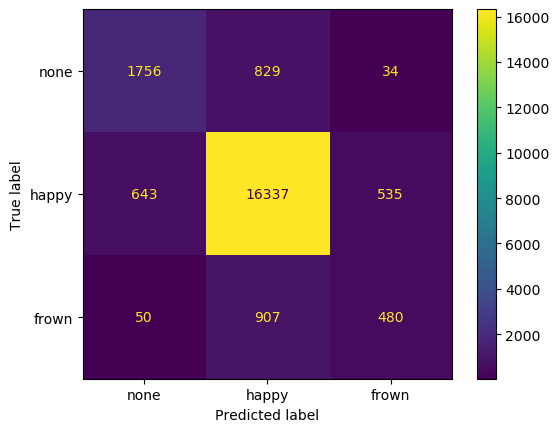

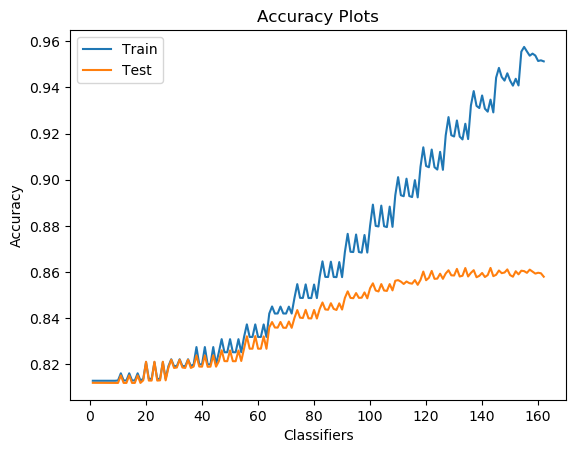

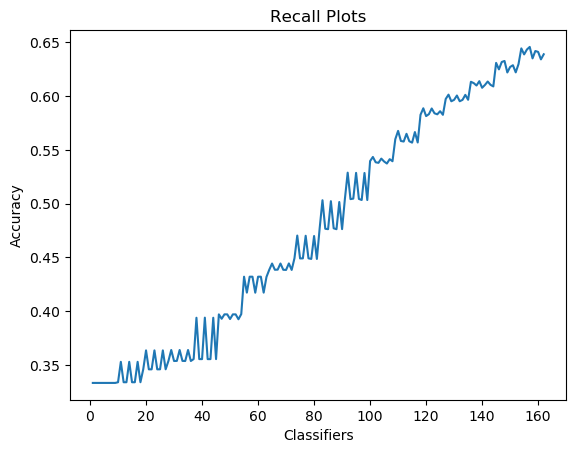

{'hyperparameters': 'max_depth: 19, min_samples_split: 3, criterion: entropy', 'train_acc': 0.9537331077165573, 'test_acc': 0.8610171063001252, 'recall_score': 0.6457525027656227, 'time': datetime.timedelta(microseconds=576345), 'confusion_matrix': array([[ 1756,   829,    34],
       [  643, 16337,   535],
       [   50,   907,   480]])}


In [16]:
dtc_classifier = dtc_search(x_train, y_train.astype('int'), x_test, y_test.astype('int'))

XG Boost


Classifier 1.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.001
Train Accuray: 81.5662594747456% ..........  Test Accuracy: 81.58175327986649% ..........   Time Required:0:00:00.636244
Recall Score: 0.3508247607979502
Classifier 2.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.005
Train Accuray: 81.69954335782667% ..........  Test Accuracy: 81.68837791479301% ..........   Time Required:0:00:00.263879
Recall Score: 0.34985531229418404
Classifier 3.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.01
Train Accuray: 81.28578382513155% ..........  Test Accuracy: 81.19697742339251% ..........   Time Required:0:00:00.264906
Recall Score: 0.3333333333333333
Classifier 4.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.05
Train Accuray: 82.11793885167242% ..........  Test Accuracy: 81.93407816049326% ..........   Time Required:0:0

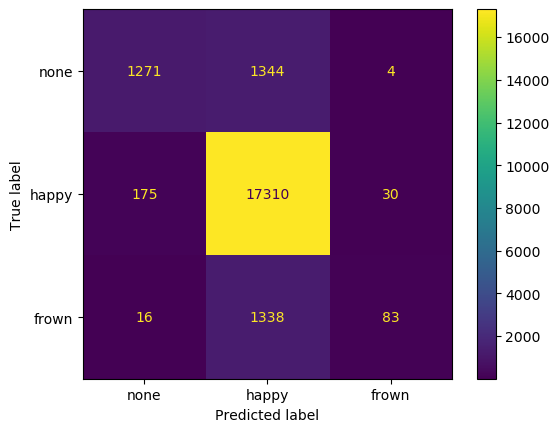

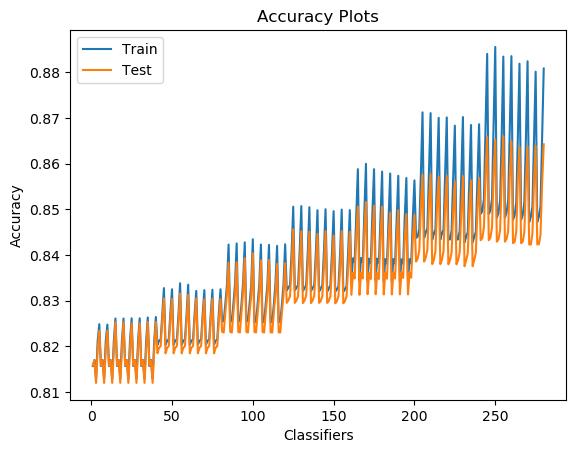

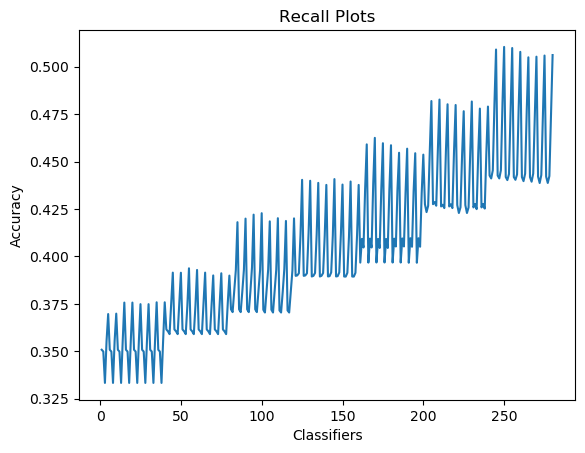

{'hyperparameters': 'max_depth:9, min_child_weight: 4, gamma: 0.05, learning_rate: 0.1', 'train_acc': 0.8855265292876846, 'test_acc': 0.8652357331602615, 'recall_score': 0.5104515666079598, 'time': datetime.timedelta(microseconds=983747), 'confusion_matrix': array([[ 1271,  1344,     4],
       [  175, 17310,    30],
       [   16,  1338,    83]])}


In [17]:
xgb_classifier = xgb_search(x_train, y_train.astype('int'), x_test, y_test.astype('int'))

BAGGING CLASSIFIER


Classifier 1.....
Hyperparameters... n_estimators: 10
Train Accuray: 99.2976518856772% ..........  Test Accuracy: 89.1984608965741% ..........   Time Required:0:00:01.759644
Recall Score: 0.6590832002597974
Classifier 2.....
Hyperparameters... n_estimators: 15
Train Accuray: 99.68823161261908% ..........  Test Accuracy: 89.43952528858189% ..........   Time Required:0:00:01.763817
Recall Score: 0.6578775898753759
Classifier 3.....
Hyperparameters... n_estimators: 20
Train Accuray: 99.81919751512483% ..........  Test Accuracy: 89.74549163228409% ..........   Time Required:0:00:02.141427
Recall Score: 0.6590751688576411
Classifier 4.....
Hyperparameters... n_estimators: 25
Train Accuray: 99.88062400037087% ..........  Test Accuracy: 89.84748041351816% ..........   Time Required:0:00:02.954806
Recall Score: 0.661814801174863
Classifier 5.....
Hyperparameters... n_estimators: 30
Train Accuray: 99.93046058274032% ..........  Test Accuracy: 89.72694821751426% ..........  

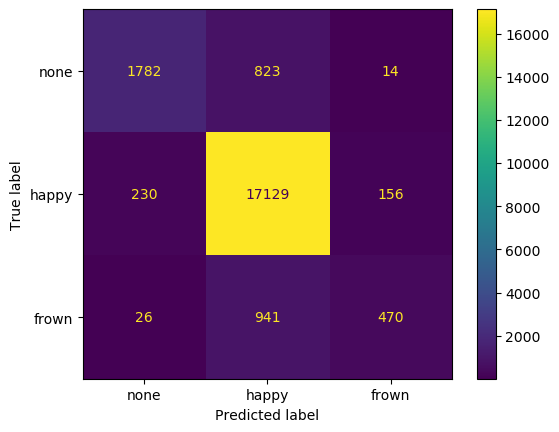

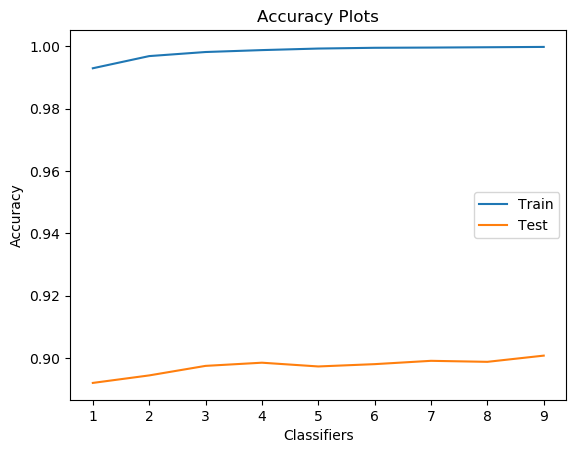

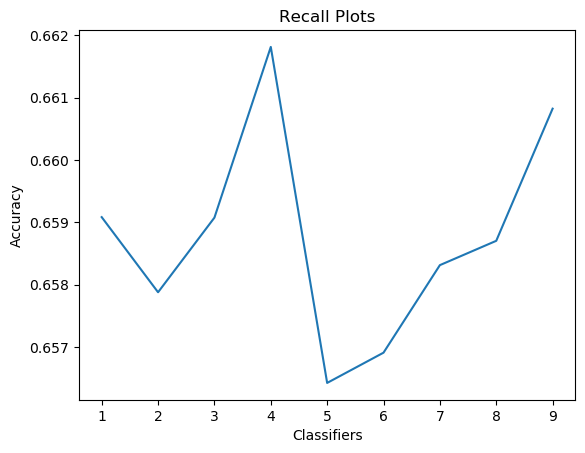

{'hyperparameters': 'n_estimators: 25', 'train_acc': 0.9988062400037088, 'test_acc': 0.8984748041351815, 'recall_score': 0.661814801174863, 'time': datetime.timedelta(seconds=2, microseconds=954806), 'confusion_matrix': array([[ 1782,   823,    14],
       [  230, 17129,   156],
       [   26,   941,   470]])}


In [18]:
bagging_classifier = bagging_search(x_train, y_train.astype('int'), x_test, y_test.astype('int'))

RANDOM FOREST CLASSIFIER


Classifier 1.....
Hyperparameters... n_estimators: 10
Train Accuray: 99.39500706984076% ..........  Test Accuracy: 88.883222845487% ..........   Time Required:0:00:00.200262
Recall Score: 0.6291438847195042
Classifier 2.....
Hyperparameters... n_estimators: 14
Train Accuray: 99.61985118564706% ..........  Test Accuracy: 89.36535162950257% ..........   Time Required:0:00:00.239323
Recall Score: 0.6349737125972538
Classifier 3.....
Hyperparameters... n_estimators: 18
Train Accuray: 99.79717669965925% ..........  Test Accuracy: 89.44416114227435% ..........   Time Required:0:00:00.249248
Recall Score: 0.630332249143422
Classifier 4.....
Hyperparameters... n_estimators: 22
Train Accuray: 99.84353631116572% ..........  Test Accuracy: 89.54151406981595% ..........   Time Required:0:00:00.250076
Recall Score: 0.6309199617706732
Classifier 5.....
Hyperparameters... n_estimators: 26
Train Accuray: 99.92234765072668% ..........  Test Accuracy: 89.78721431551621% ......

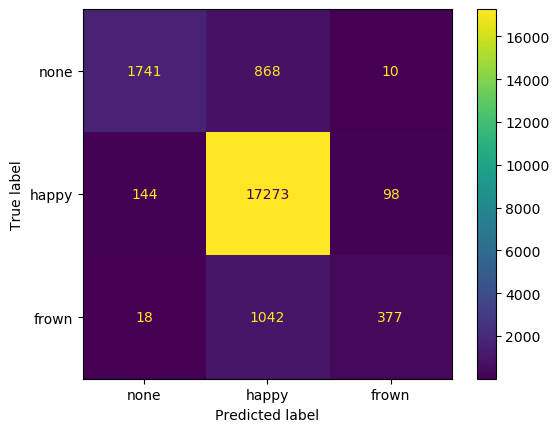

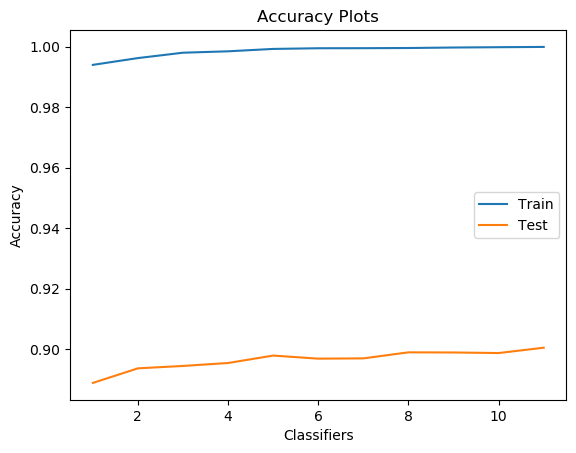

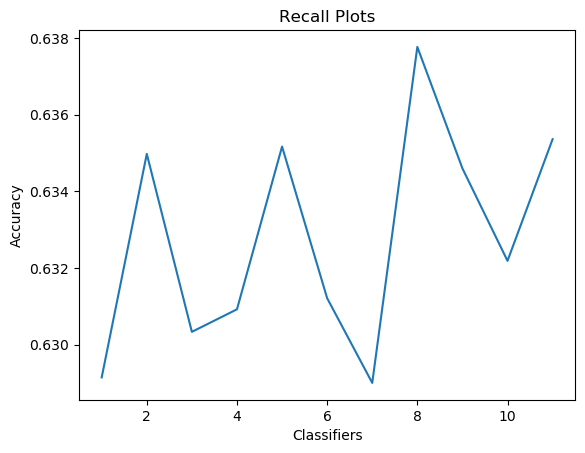

{'hyperparameters': 'n_estimators: 38', 'train_acc': 0.9995248139820588, 'test_acc': 0.8989383895044273, 'recall_score': 0.6377643116683905, 'time': datetime.timedelta(microseconds=305399), 'confusion_matrix': array([[ 1741,   868,    10],
       [  144, 17273,    98],
       [   18,  1042,   377]])}


In [19]:
rfc_classifier = rfc_search(x_train, y_train.astype('int'), x_test, y_test.astype('int'))

GAUSSAIN NAIVE BAYES


Classifier 1.....
Hyperparameters... var_smoothing: 1e-10
Train Accuray: 81.20117753413226% ..........  Test Accuracy: 81.12743961800565% ..........   Time Required:0:00:00.012637
Recall Score: 0.3332643512055759
Classifier 2.....
Hyperparameters... var_smoothing: 2e-10
Train Accuray: 81.20117753413226% ..........  Test Accuracy: 81.12743961800565% ..........   Time Required:0:00:00.010294
Recall Score: 0.3332643512055759
Classifier 3.....
Hyperparameters... var_smoothing: 3e-10
Train Accuray: 81.20117753413226% ..........  Test Accuracy: 81.12743961800565% ..........   Time Required:0:00:00.009974
Recall Score: 0.3332643512055759
Classifier 4.....
Hyperparameters... var_smoothing: 4e-10
Train Accuray: 81.20117753413226% ..........  Test Accuracy: 81.12743961800565% ..........   Time Required:0:00:00.010102
Recall Score: 0.3332643512055759
Classifier 5.....
Hyperparameters... var_smoothing: 5e-10
Train Accuray: 81.20117753413226% ..........  Test Accuracy: 81.127

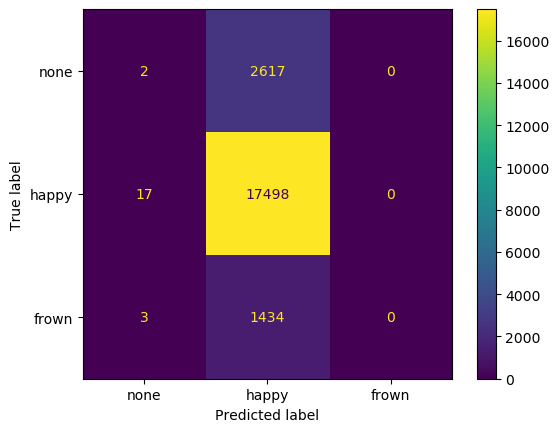

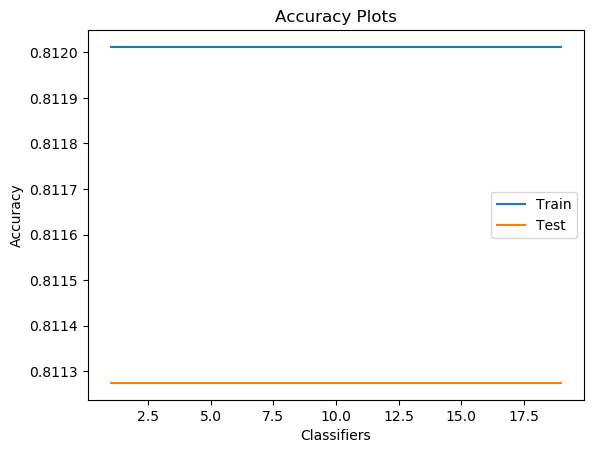

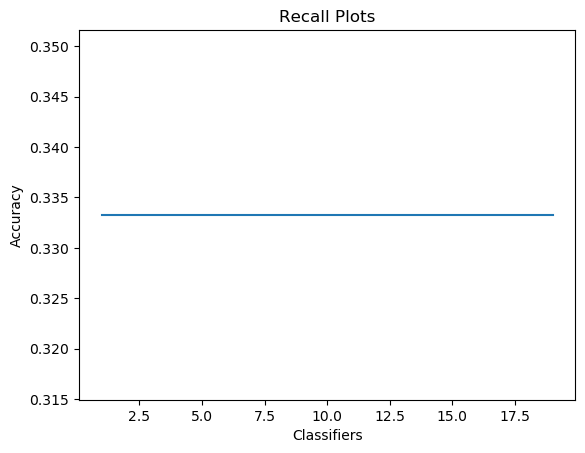

{'hyperparameters': 'var_smoothing: 1e-10', 'train_acc': 0.8120117753413226, 'test_acc': 0.8112743961800566, 'recall_score': 0.3332643512055759, 'time': datetime.timedelta(microseconds=12637), 'confusion_matrix': array([[    2,  2617,     0],
       [   17, 17498,     0],
       [    3,  1434,     0]])}


In [20]:
gnb_classifier = gnb_search(x_train, y_train.astype('int'), x_test, y_test.astype('int'))

K NEAREST NEIGHBOURS


Classifier 1.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 1
Train Accuray: 85.55898101573909% ..........  Test Accuracy: 78.3876500857633% ..........   Time Required:0:00:00.069871
Recall Score: 0.43108519942163026
Classifier 2.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 2
Train Accuray: 84.55181845576134% ..........  Test Accuracy: 77.45584349357935% ..........   Time Required:0:00:00.067493
Recall Score: 0.40905912052970156
Classifier 3.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 3
Train Accuray: 84.29568160218818% ..........  Test Accuracy: 77.2982244680358% ..........   Time Required:0:00:00.070143
Recall Score: 0.40450106551410087
Classifier 4.....
Hyperparameters... n_neighbours: 4, weight: distance, distance_metric: 1
Train Accuray: 100.0% ..........  Test Accuracy: 79.77840619350053% ..........   Time Required:0:00:00.077070
Recall Score: 0.45430813489561556
Classi

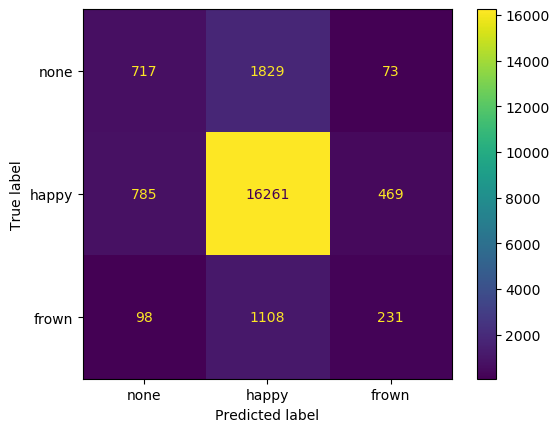

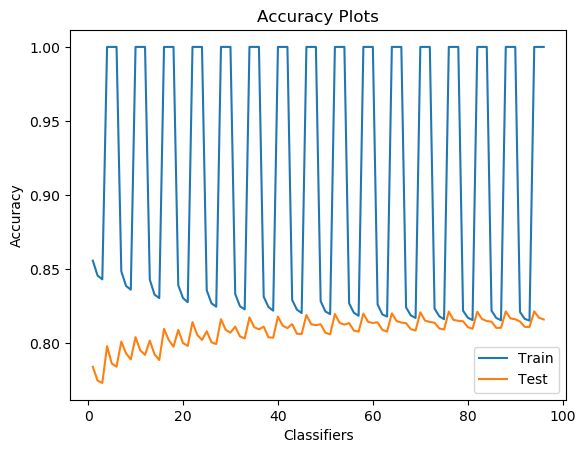

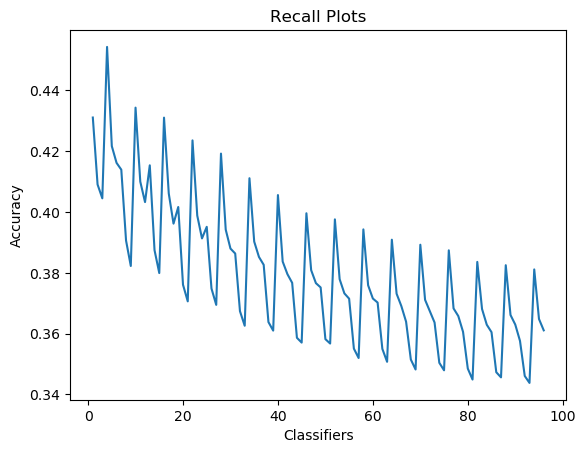

{'hyperparameters': 'n_neighbours: 4, weight: distance, distance_metric: 1', 'train_acc': 1.0, 'test_acc': 0.7977840619350053, 'recall_score': 0.45430813489561556, 'time': datetime.timedelta(microseconds=77070), 'confusion_matrix': array([[  717,  1829,    73],
       [  785, 16261,   469],
       [   98,  1108,   231]])}


In [21]:
knn_classifier = knn_search(x_train, y_train.astype('int'), x_test, y_test.astype('int'))

In [ ]:
# svc_classifier = svc_search(x_train, y_train.astype('int'), x_test, y_test.astype('int'))

### ***Training Models (Outliers Removed)***

In [15]:
data2 = pd.read_excel('generated_data/data_new.xlsx')
# data2 = data2.drop(columns=['timestamp', 'state'])

data_y2 = data2['Class']
data_x2 = data2.drop(columns=['Class'])

# labels = ['none', 'happy', 'frown']
labels = {'none': 0, 'happy': 1, 'frown': 2}

for i in range (len(data_y2)):
    data_y2.iloc[i] = labels[data_y2[i]]

x_train2, x_test2, y_train2, y_test2 = split(data_x2, data_y2, train_size=0.8)

DECISION TREE CLASSIFIER


Classifier 1.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: entropy
Train Accuray: 82.48241072613833% ..........  Test Accuracy: 82.23862369245474% ..........   Time Required:0:00:00.094239
Recall Score: 0.35833333333333334
Classifier 2.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: gini
Train Accuray: 82.48241072613833% ..........  Test Accuracy: 82.23862369245474% ..........   Time Required:0:00:00.079859
Recall Score: 0.35833333333333334
Classifier 3.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: log_loss
Train Accuray: 82.48241072613833% ..........  Test Accuracy: 82.23862369245474% ..........   Time Required:0:00:00.091087
Recall Score: 0.35833333333333334
Classifier 4.....
Hyperparameters... max_depth:2, min_samples_split:3, criterion: entropy
Train Accuray: 82.48241072613833% ..........  Test Accuracy: 82.23862369245474% ..........   Time Required:0:00:00.091758
Recall Score: 0.358333333

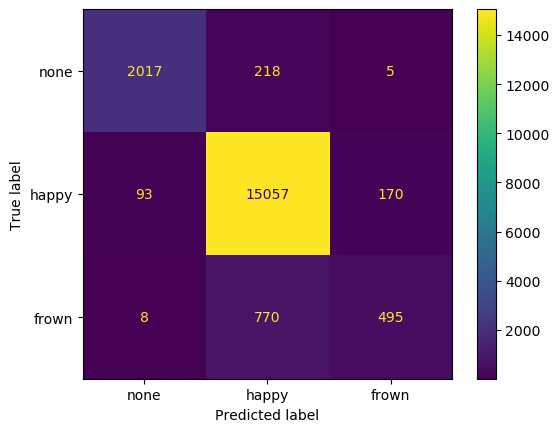

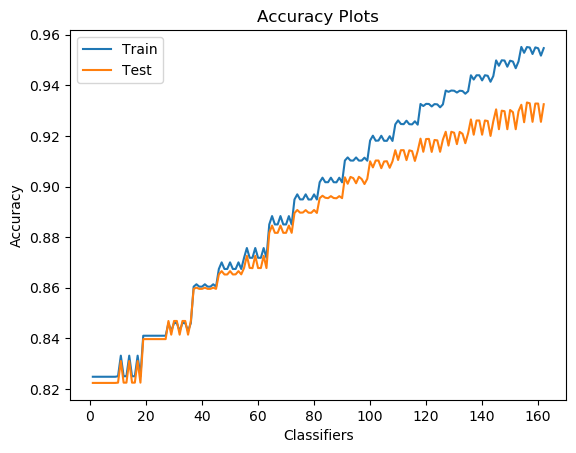

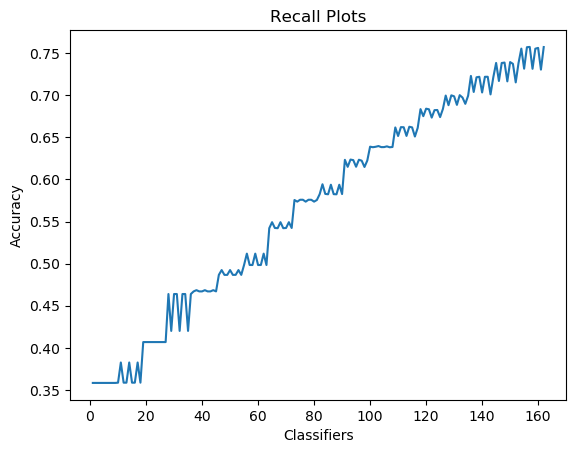

{'hyperparameters': 'max_depth: 19, min_samples_split: 3, criterion: entropy', 'train_acc': 0.9549316341431037, 'test_acc': 0.9328837678542983, 'recall_score': 0.7573748580635761, 'time': datetime.timedelta(microseconds=556307), 'confusion_matrix': array([[ 2017,   218,     5],
       [   93, 15057,   170],
       [    8,   770,   495]])}


In [16]:
dtc_classifier = dtc_search(x_train2, y_train2.astype('int'), x_test2, y_test2.astype('int'))


XG Boost


Classifier 1.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.001
Train Accuray: 83.30678348599496% ..........  Test Accuracy: 83.09350607975362% ..........   Time Required:0:00:00.570167
Recall Score: 0.38254576961332837
Classifier 2.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.005
Train Accuray: 83.01606265763972% ..........  Test Accuracy: 82.80677534115648% ..........   Time Required:0:00:00.254326
Recall Score: 0.38111673194081813
Classifier 3.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.01
Train Accuray: 83.2948360546927% ..........  Test Accuracy: 83.08288642276854% ..........   Time Required:0:00:00.249774
Recall Score: 0.3822481505657093
Classifier 4.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.05
Train Accuray: 86.3387760520377% ..........  Test Accuracy: 86.21568523336697% ..........   Time Required:0:0

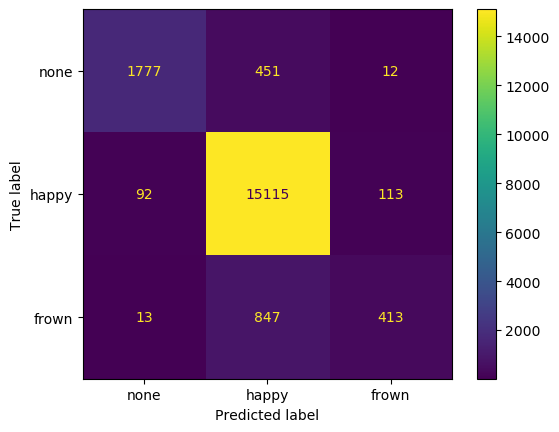

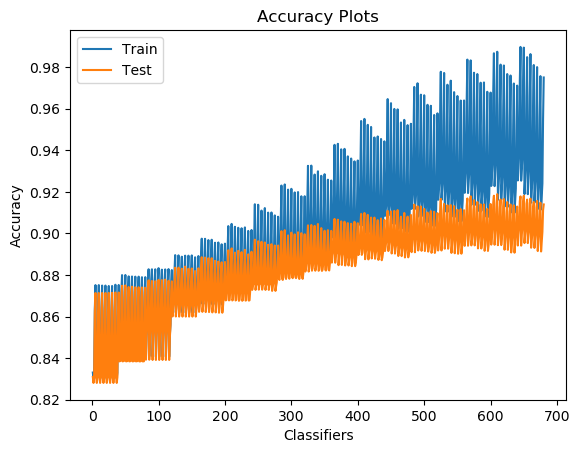

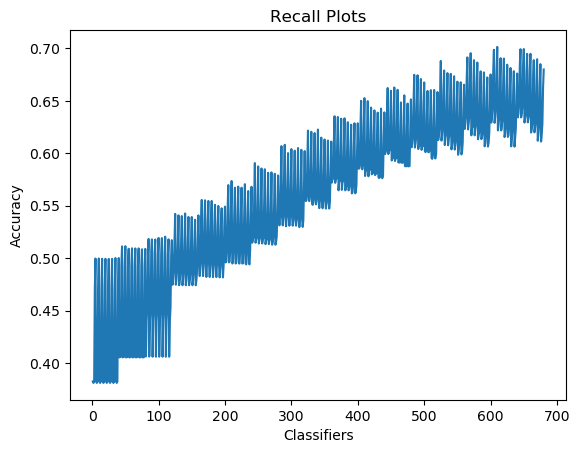

{'hyperparameters': 'max_depth:18, min_child_weight: 4, gamma: 0.05, learning_rate: 0.1', 'train_acc': 0.9874020974379397, 'test_acc': 0.9188658206339935, 'recall_score': 0.7014509498557392, 'time': datetime.timedelta(seconds=3, microseconds=135222), 'confusion_matrix': array([[ 1777,   451,    12],
       [   92, 15115,   113],
       [   13,   847,   413]])}


In [17]:
xgb_classifier = xgb_search(x_train2, y_train2.astype('int'), x_test2, y_test2.astype('int'))


BAGGING CLASSIFIER


Classifier 1.....
Hyperparameters... n_estimators: 10
Train Accuray: 99.67343687773796% ..........  Test Accuracy: 94.716720649923% ..........   Time Required:0:00:01.891754
Recall Score: 0.8071194955013503
Classifier 2.....
Hyperparameters... n_estimators: 15
Train Accuray: 99.89778308774724% ..........  Test Accuracy: 95.01407104550523% ..........   Time Required:0:00:01.773595
Recall Score: 0.8192270378095389
Classifier 3.....
Hyperparameters... n_estimators: 20
Train Accuray: 99.9084030266826% ..........  Test Accuracy: 95.16805607178888% ..........   Time Required:0:00:02.266582
Recall Score: 0.8191227967623748
Classifier 4.....
Hyperparameters... n_estimators: 25
Train Accuray: 99.96017522899243% ..........  Test Accuracy: 95.29018212711729% ..........   Time Required:0:00:03.027480
Recall Score: 0.8258665279117867
Classifier 5.....
Hyperparameters... n_estimators: 30
Train Accuray: 99.97743262976238% ..........  Test Accuracy: 95.2636329846546% ..........   

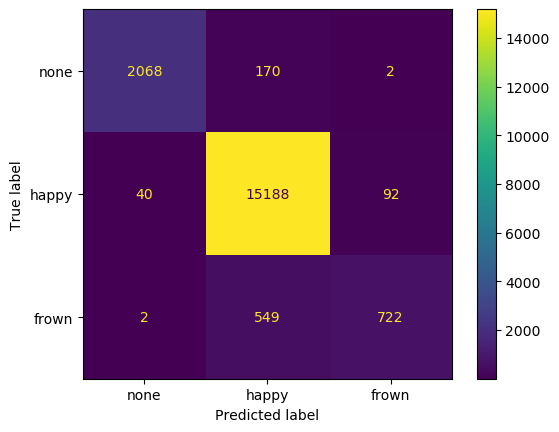

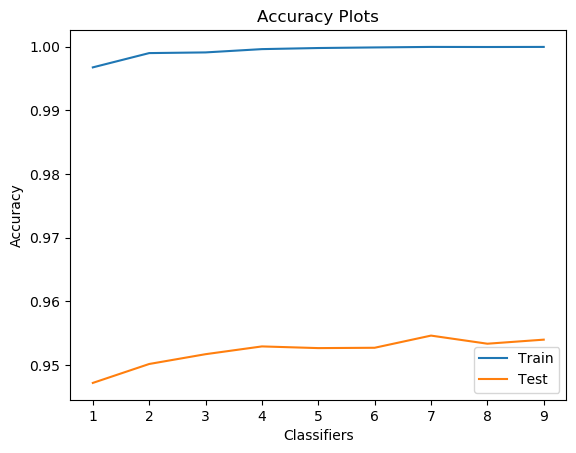

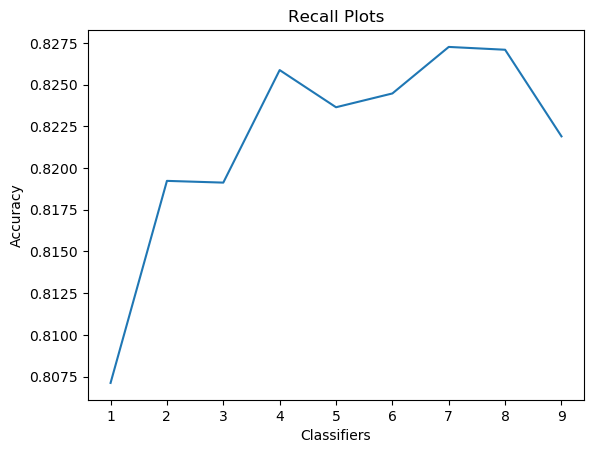

{'hyperparameters': 'n_estimators: 40', 'train_acc': 0.9999469003053233, 'test_acc': 0.9546009663887857, 'recall_score': 0.8272540922764025, 'time': datetime.timedelta(seconds=4, microseconds=225305), 'confusion_matrix': array([[ 2068,   170,     2],
       [   40, 15188,    92],
       [    2,   549,   722]])}


In [18]:
bagging_classifier = bagging_search(x_train2, y_train2.astype('int'), x_test2, y_test2.astype('int'))


RANDOM FOREST CLASSIFIER


Classifier 1.....
Hyperparameters... n_estimators: 10
Train Accuray: 99.57520244258595% ..........  Test Accuracy: 93.22465884351936% ..........   Time Required:0:00:00.174281
Recall Score: 0.7400589586154115
Classifier 2.....
Hyperparameters... n_estimators: 14
Train Accuray: 99.76370635868844% ..........  Test Accuracy: 93.25120798598205% ..........   Time Required:0:00:00.218389
Recall Score: 0.7395614565548551
Classifier 3.....
Hyperparameters... n_estimators: 18
Train Accuray: 99.8805256869773% ..........  Test Accuracy: 93.34678489884777% ..........   Time Required:0:00:00.225770
Recall Score: 0.7362667280121116
Classifier 4.....
Hyperparameters... n_estimators: 22
Train Accuray: 99.93229788928714% ..........  Test Accuracy: 93.49015026814634% ..........   Time Required:0:00:00.211709
Recall Score: 0.7431955777830649
Classifier 5.....
Hyperparameters... n_estimators: 26
Train Accuray: 99.95752024425859% ..........  Test Accuracy: 93.6706844368927% .....

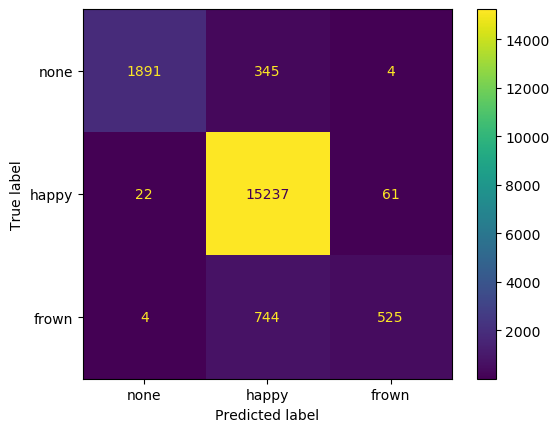

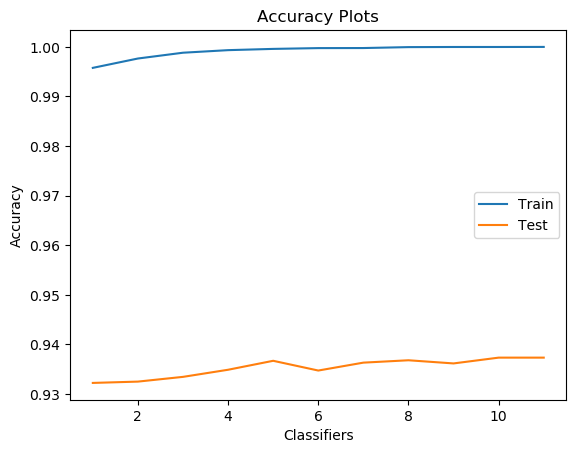

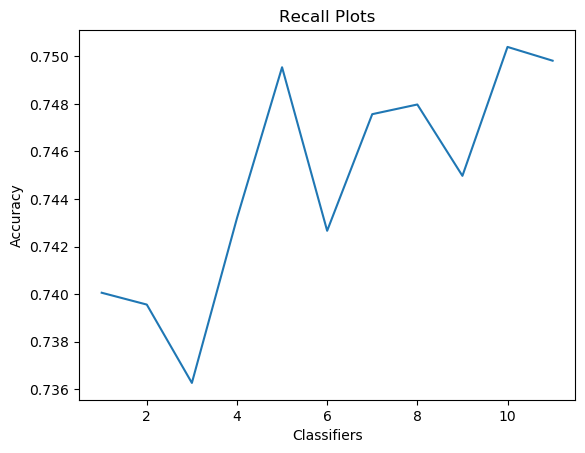

{'hyperparameters': 'n_estimators: 46', 'train_acc': 0.9999601752289924, 'test_acc': 0.9373440237880316, 'recall_score': 0.7503967666941213, 'time': datetime.timedelta(microseconds=304743), 'confusion_matrix': array([[ 1891,   345,     4],
       [   22, 15237,    61],
       [    4,   744,   525]])}


In [19]:
rfc_classifier = rfc_search(x_train2, y_train2.astype('int'), x_test2, y_test2.astype('int'))


GAUSSAIN NAIVE BAYES


Classifier 1.....
Hyperparameters... var_smoothing: 1e-10
Train Accuray: 78.08442851453604% ..........  Test Accuracy: 78.23501300907981% ..........   Time Required:0:00:00.011553
Recall Score: 0.3700417795589867
Classifier 2.....
Hyperparameters... var_smoothing: 2e-10
Train Accuray: 79.49024293110315% ..........  Test Accuracy: 79.59432910316997% ..........   Time Required:0:00:00.009931
Recall Score: 0.3537635957904582
Classifier 3.....
Hyperparameters... var_smoothing: 3e-10
Train Accuray: 81.1310234966149% ..........  Test Accuracy: 80.99612382520046% ..........   Time Required:0:00:00.009712
Recall Score: 0.33765947642575905
Classifier 4.....
Hyperparameters... var_smoothing: 4e-10
Train Accuray: 81.47882649674764% ..........  Test Accuracy: 81.30940370626028% ..........   Time Required:0:00:00.009946
Recall Score: 0.33366120818198414
Classifier 5.....
Hyperparameters... var_smoothing: 5e-10
Train Accuray: 81.49210142041683% ..........  Test Accuracy: 81.34

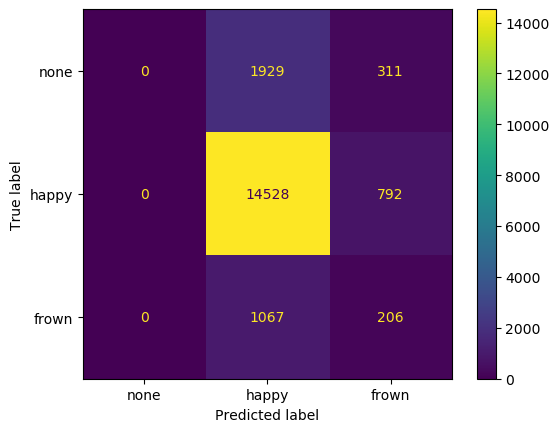

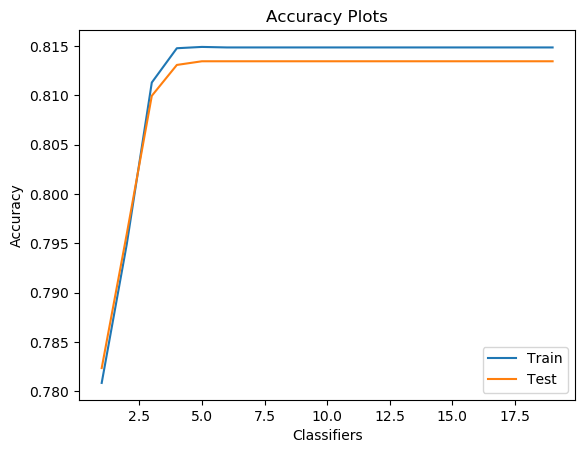

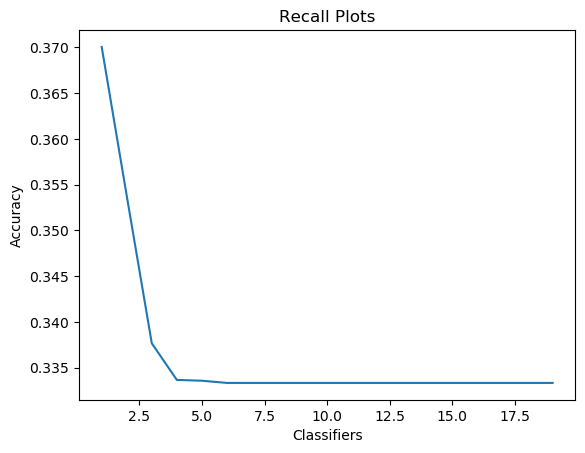

{'hyperparameters': 'var_smoothing: 1e-10', 'train_acc': 0.7808442851453604, 'test_acc': 0.782350130090798, 'recall_score': 0.3700417795589867, 'time': datetime.timedelta(microseconds=11553), 'confusion_matrix': array([[    0,  1929,   311],
       [    0, 14528,   792],
       [    0,  1067,   206]])}


In [20]:
gnb_classifier = gnb_search(x_train2, y_train2.astype('int'), x_test2, y_test2.astype('int'))


K NEAREST NEIGHBOURS


Classifier 1.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 1
Train Accuray: 98.94066109119872% ..........  Test Accuracy: 97.70615409122286% ..........   Time Required:0:00:00.064975
Recall Score: 0.9262151444504054
Classifier 2.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 2
Train Accuray: 99.05084295765299% ..........  Test Accuracy: 97.89730791695428% ..........   Time Required:0:00:00.060423
Recall Score: 0.9305147788463013
Classifier 3.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 3
Train Accuray: 99.07341032789061% ..........  Test Accuracy: 97.92916688790953% ..........   Time Required:0:00:00.062735
Recall Score: 0.9311395206968358
Classifier 4.....
Hyperparameters... n_neighbours: 4, weight: distance, distance_metric: 1
Train Accuray: 100.0% ..........  Test Accuracy: 98.24244676896936% ..........   Time Required:0:00:00.061013
Recall Score: 0.9591452448392327
Classifi

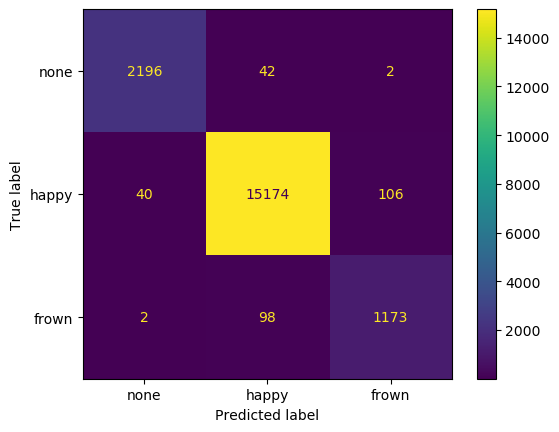

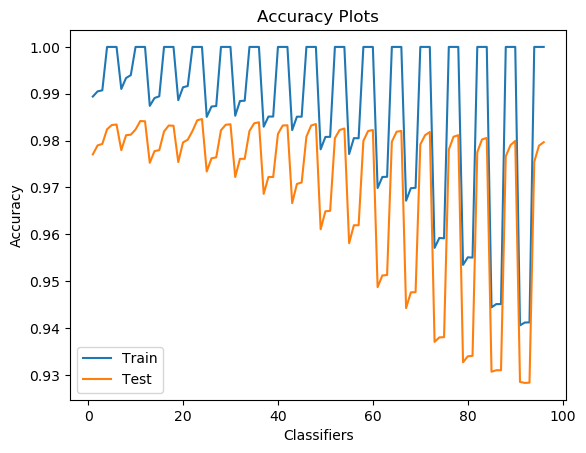

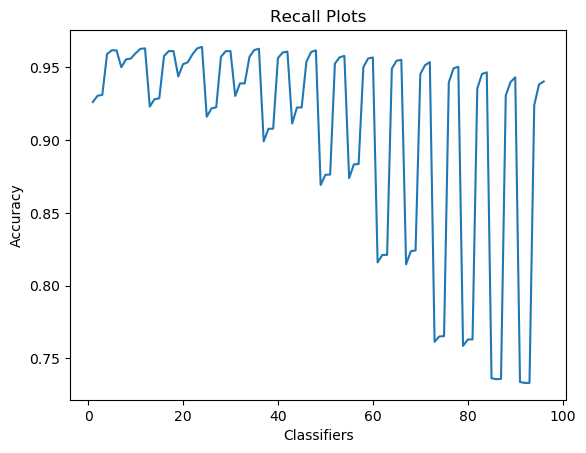

{'hyperparameters': 'n_neighbours: 7, weight: distance, distance_metric: 3', 'train_acc': 1.0, 'test_acc': 0.9846014973716349, 'recall_score': 0.9640908404345496, 'time': datetime.timedelta(microseconds=62222), 'confusion_matrix': array([[ 2196,    42,     2],
       [   40, 15174,   106],
       [    2,    98,  1173]])}


In [21]:
knn_classifier = knn_search(x_train2, y_train2.astype('int'), x_test2, y_test2.astype('int'))


In [25]:
save_model('saved_models/new_data_models/', 'dtc.pkl', dtc_classifier)
save_model('saved_models/new_data_models/', 'xgb.pkl', xgb_classifier)
save_model('saved_models/new_data_models/', 'bag.pkl', bagging_classifier)
save_model('saved_models/new_data_models/', 'rfc.pkl', rfc_classifier)
save_model('saved_models/new_data_models/', 'gnb.pkl', gnb_classifier)
save_model('saved_models/new_data_models/', 'knn.pkl', knn_classifier)


### ***Training Models (Outlier Removed ICA)***

In [27]:
data3 = pd.read_excel('generated_data/data_new.xlsx')
# data2 = data2.drop(columns=['timestamp', 'state'])

data_y3 = data3['Class']
data_x3 = data3.drop(columns=['Class'])

# labels = ['none', 'happy', 'frown']
labels = {'none': 0, 'happy': 1, 'frown': 2}

for i in range (len(data_y3)):
    data_y3.iloc[i] = labels[data_y3[i]]

x_train3, x_test3, y_train3, y_test3 = split(data_x3, data_y3, train_size=0.8)

DECISION TREE CLASSIFIER


Classifier 1.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: entropy
Train Accuray: 82.51161555821054% ..........  Test Accuracy: 82.12180746561886% ..........   Time Required:0:00:00.097941
Recall Score: 0.3638790035587189
Classifier 2.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: gini
Train Accuray: 82.51161555821054% ..........  Test Accuracy: 82.12180746561886% ..........   Time Required:0:00:00.079133
Recall Score: 0.3638790035587189
Classifier 3.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: log_loss
Train Accuray: 82.51161555821054% ..........  Test Accuracy: 82.12180746561886% ..........   Time Required:0:00:00.091163
Recall Score: 0.3638790035587189
Classifier 4.....
Hyperparameters... max_depth:2, min_samples_split:3, criterion: entropy
Train Accuray: 82.51161555821054% ..........  Test Accuracy: 82.12180746561886% ..........   Time Required:0:00:00.088515
Recall Score: 0.363879003558

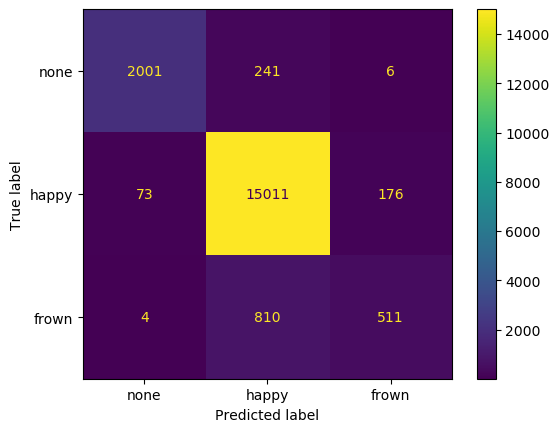

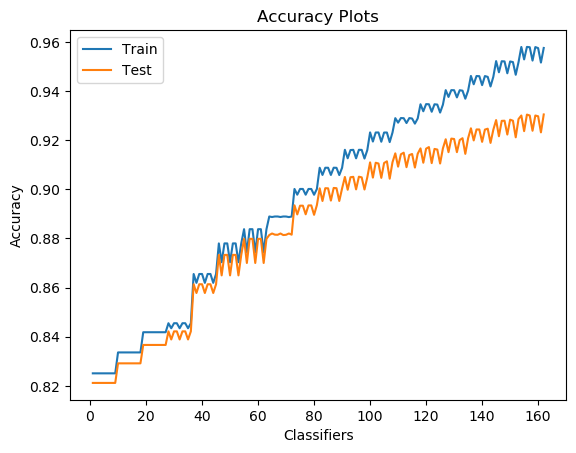

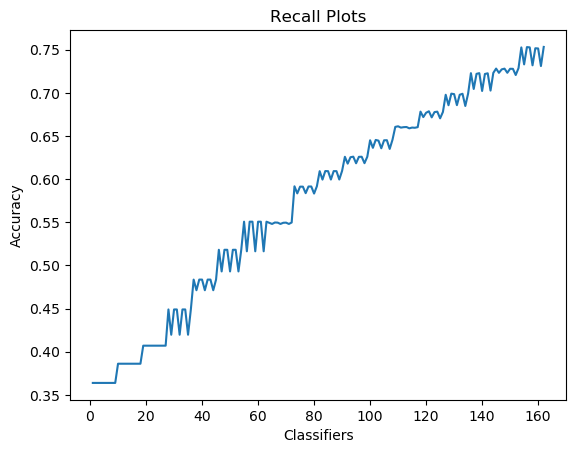

{'hyperparameters': 'max_depth: 19, min_samples_split: 4, criterion: log_loss', 'train_acc': 0.9574936944112571, 'test_acc': 0.9304412467477301, 'recall_score': 0.7531559211497235, 'time': datetime.timedelta(microseconds=551847), 'confusion_matrix': array([[ 2001,   241,     6],
       [   73, 15011,   176],
       [    4,   810,   511]])}


In [28]:
dtc_classifier = dtc_search(x_train3, y_train3.astype('int'), x_test3, y_test3.astype('int'))

XG Boost


Classifier 1.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.001
Train Accuray: 83.9838045931236% ..........  Test Accuracy: 83.48643338820156% ..........   Time Required:0:00:00.280133
Recall Score: 0.40198695136417556
Classifier 2.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.005
Train Accuray: 83.93468737554758% ..........  Test Accuracy: 83.42802527478362% ..........   Time Required:0:00:00.248601
Recall Score: 0.40035587188612104
Classifier 3.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.01
Train Accuray: 83.93468737554758% ..........  Test Accuracy: 83.42802527478362% ..........   Time Required:0:00:00.262047
Recall Score: 0.40035587188612104
Classifier 4.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.05
Train Accuray: 86.37992831541219% ..........  Test Accuracy: 85.89709552381458% ..........   Time Required:0

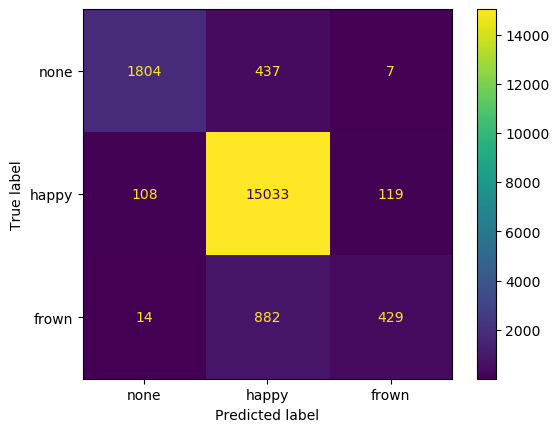

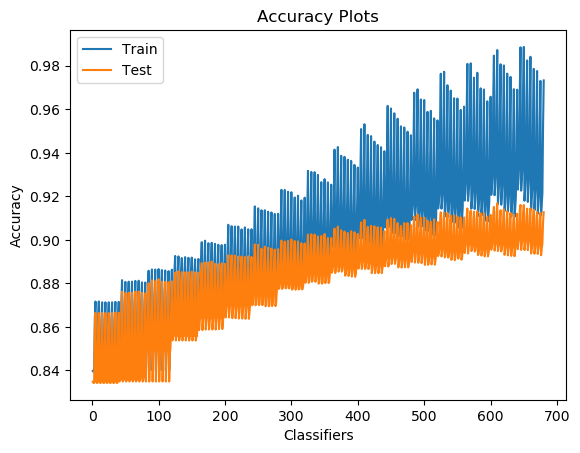

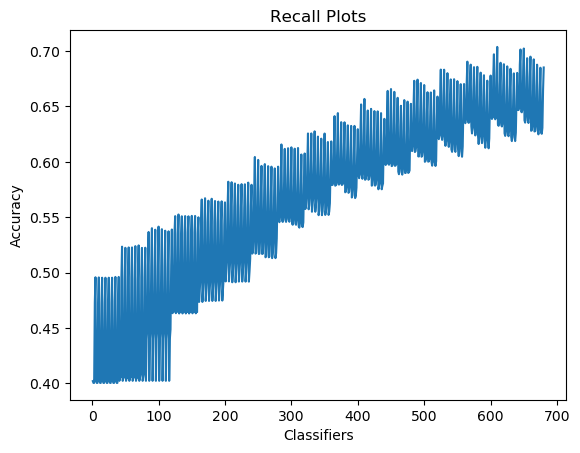

{'hyperparameters': 'max_depth:18, min_child_weight: 4, gamma: 0.05, learning_rate: 0.1', 'train_acc': 0.9872162485065711, 'test_acc': 0.916794987521903, 'recall_score': 0.703796398875837, 'time': datetime.timedelta(seconds=3, microseconds=235176), 'confusion_matrix': array([[ 1804,   437,     7],
       [  108, 15033,   119],
       [   14,   882,   429]])}


In [29]:
xgb_classifier = xgb_search(x_train3, y_train3.astype('int'), x_test3, y_test3.astype('int'))

BAGGING CLASSIFIER


Classifier 1.....
Hyperparameters... n_estimators: 10
Train Accuray: 99.68936678614098% ..........  Test Accuracy: 94.65831253650508% ..........   Time Required:0:00:01.769260
Recall Score: 0.8074835026039983
Classifier 2.....
Hyperparameters... n_estimators: 15
Train Accuray: 99.89645559538033% ..........  Test Accuracy: 95.19460521425158% ..........   Time Required:0:00:01.813675
Recall Score: 0.8286183266761175
Classifier 3.....
Hyperparameters... n_estimators: 20
Train Accuray: 99.93495287402098% ..........  Test Accuracy: 95.03000053098285% ..........   Time Required:0:00:02.219045
Recall Score: 0.8157299810440439
Classifier 4.....
Hyperparameters... n_estimators: 25
Train Accuray: 99.96548519846012% ..........  Test Accuracy: 95.35920989752032% ..........   Time Required:0:00:03.007042
Recall Score: 0.8348321117021825
Classifier 5.....
Hyperparameters... n_estimators: 30
Train Accuray: 99.9721226602947% ..........  Test Accuracy: 95.10964795837094% ..........

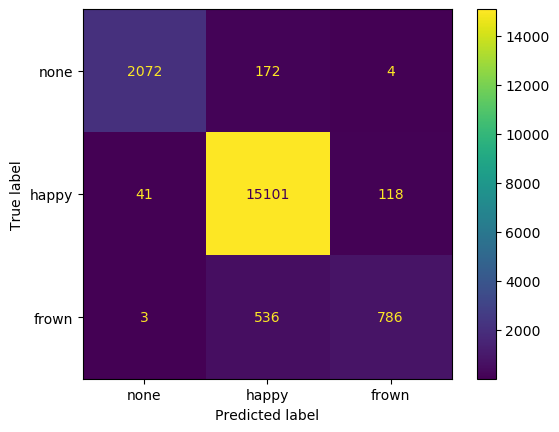

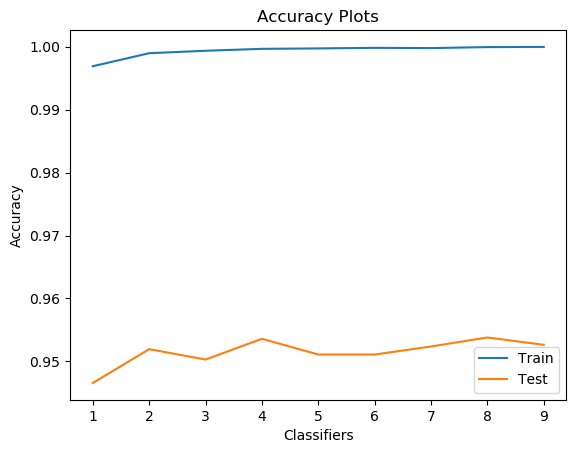

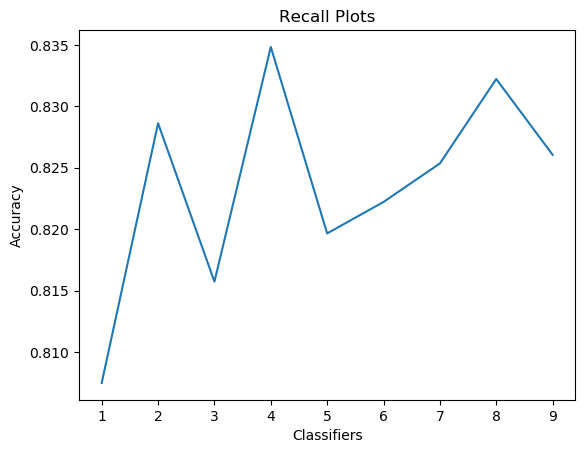

{'hyperparameters': 'n_estimators: 25', 'train_acc': 0.9996548519846011, 'test_acc': 0.9535920989752031, 'recall_score': 0.8348321117021825, 'time': datetime.timedelta(seconds=3, microseconds=7042), 'confusion_matrix': array([[ 2072,   172,     4],
       [   41, 15101,   118],
       [    3,   536,   786]])}


In [30]:
bagging_classifier = bagging_search(x_train3, y_train3.astype('int'), x_test3, y_test3.astype('int'))

RANDOM FOREST CLASSIFIER


Classifier 1.....
Hyperparameters... n_estimators: 10
Train Accuray: 99.58980485862206% ..........  Test Accuracy: 93.00164604683269% ..........   Time Required:0:00:00.167921
Recall Score: 0.7376643628584354
Classifier 2.....
Hyperparameters... n_estimators: 14
Train Accuray: 99.82344351519978% ..........  Test Accuracy: 93.21934901502682% ..........   Time Required:0:00:00.195083
Recall Score: 0.7441767322790147
Classifier 3.....
Hyperparameters... n_estimators: 18
Train Accuray: 99.87654320987654% ..........  Test Accuracy: 93.26713747145968% ..........   Time Required:0:00:00.199364
Recall Score: 0.7411322674630508
Classifier 4.....
Hyperparameters... n_estimators: 22
Train Accuray: 99.92035045798487% ..........  Test Accuracy: 93.20872935804174% ..........   Time Required:0:00:00.213861
Recall Score: 0.7378823704328975
Classifier 5.....
Hyperparameters... n_estimators: 26
Train Accuray: 99.95619275189168% ..........  Test Accuracy: 93.2989964424149% ....

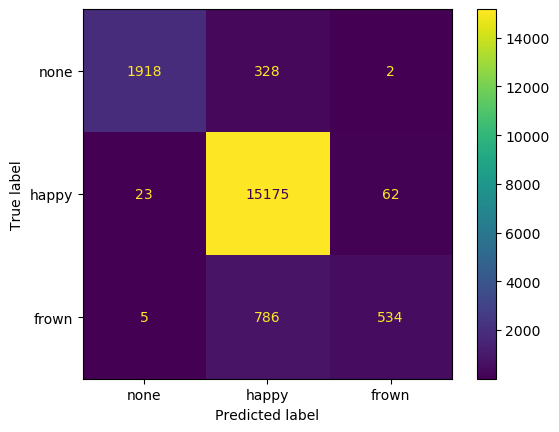

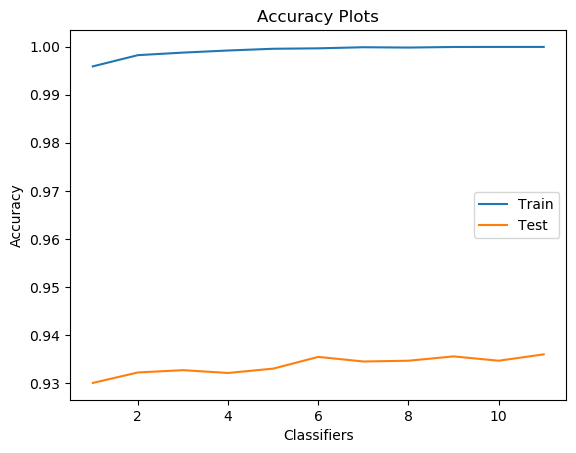

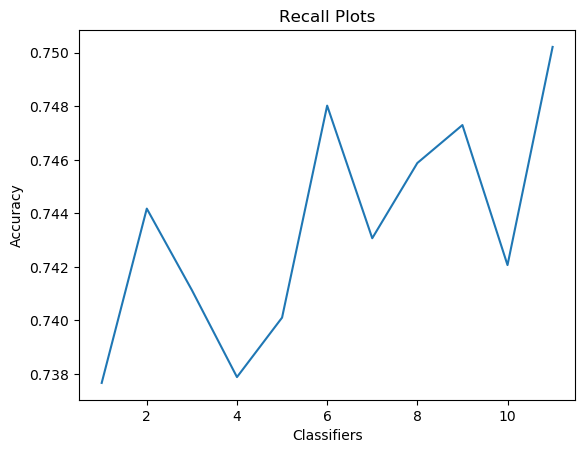

{'hyperparameters': 'n_estimators: 50', 'train_acc': 0.9999469003053233, 'test_acc': 0.9359634683799714, 'recall_score': 0.7502171989813927, 'time': datetime.timedelta(microseconds=304019), 'confusion_matrix': array([[ 1918,   328,     2],
       [   23, 15175,    62],
       [    5,   786,   534]])}


In [31]:
rfc_classifier = rfc_search(x_train3, y_train3.astype('int'), x_test3, y_test3.astype('int'))

GAUSSAIN NAIVE BAYES


Classifier 1.....
Hyperparameters... var_smoothing: 1e-10
Train Accuray: 78.12159830080977% ..........  Test Accuracy: 77.53411564806457% ..........   Time Required:0:00:00.014481
Recall Score: 0.3665140911826042
Classifier 2.....
Hyperparameters... var_smoothing: 2e-10
Train Accuray: 79.56723748838445% ..........  Test Accuracy: 79.04210693994584% ..........   Time Required:0:00:00.010456
Recall Score: 0.3531907317193798
Classifier 3.....
Hyperparameters... var_smoothing: 3e-10
Train Accuray: 81.00358422939068% ..........  Test Accuracy: 80.54478840333458% ..........   Time Required:0:00:00.010286
Recall Score: 0.33754824138414236
Classifier 4.....
Hyperparameters... var_smoothing: 4e-10
Train Accuray: 81.51997876012213% ..........  Test Accuracy: 80.98019433972283% ..........   Time Required:0:00:00.010160
Recall Score: 0.3340556558437811
Classifier 5.....
Hyperparameters... var_smoothing: 5e-10
Train Accuray: 81.57307845479889% ..........  Test Accuracy: 81.02

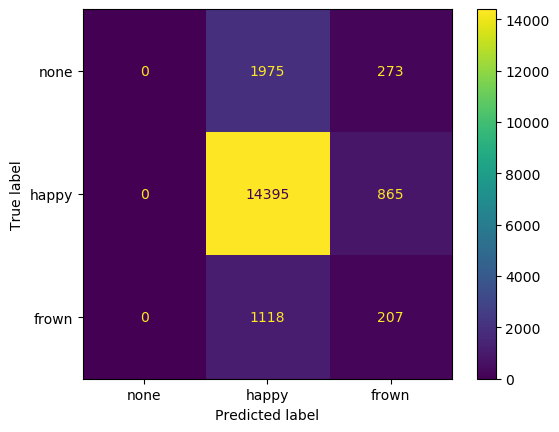

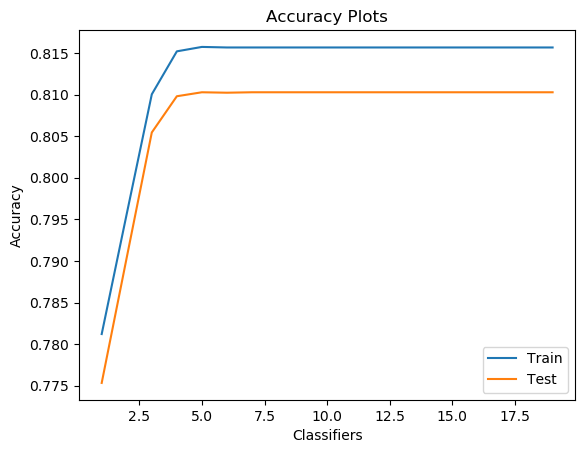

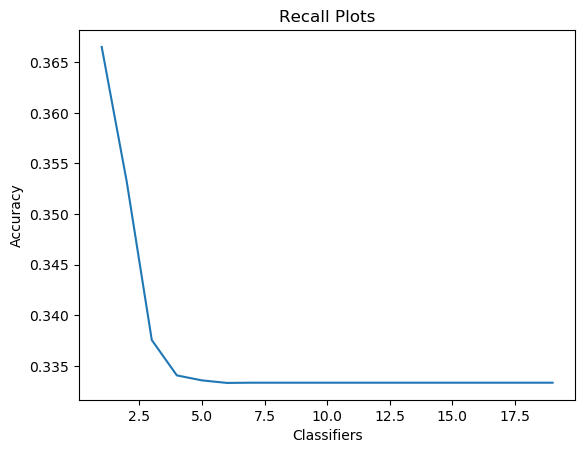

{'hyperparameters': 'var_smoothing: 1e-10', 'train_acc': 0.7812159830080977, 'test_acc': 0.7753411564806457, 'recall_score': 0.3665140911826042, 'time': datetime.timedelta(microseconds=14481), 'confusion_matrix': array([[    0,  1975,   273],
       [    0, 14395,   865],
       [    0,  1118,   207]])}


In [32]:
gnb_classifier = gnb_search(x_train3, y_train3.astype('int'), x_test3, y_test3.astype('int'))

K NEAREST NEIGHBOURS


Classifier 1.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 1
Train Accuray: 98.92605867516262% ..........  Test Accuracy: 97.72739340519301% ..........   Time Required:0:00:00.063839
Recall Score: 0.928795196179815
Classifier 2.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 2
Train Accuray: 99.03358555688305% ..........  Test Accuracy: 97.90792757393936% ..........   Time Required:0:00:00.062655
Recall Score: 0.9322607628606999
Classifier 3.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 3
Train Accuray: 99.06013540422143% ..........  Test Accuracy: 97.95571603037222% ..........   Time Required:0:00:00.063775
Recall Score: 0.9330432490662899
Classifier 4.....
Hyperparameters... n_neighbours: 4, weight: distance, distance_metric: 1
Train Accuray: 100.0% ..........  Test Accuracy: 98.15748951308872% ..........   Time Required:0:00:00.063496
Recall Score: 0.9558098327263972
Classifie

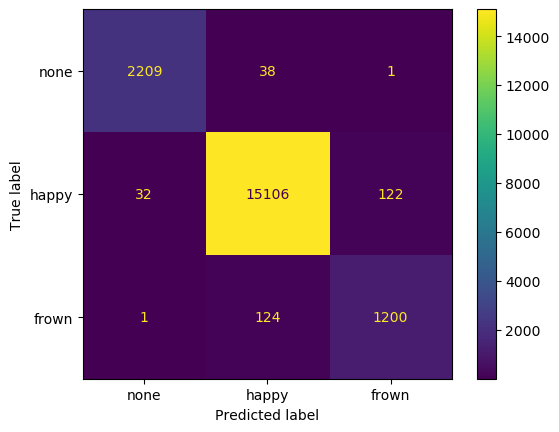

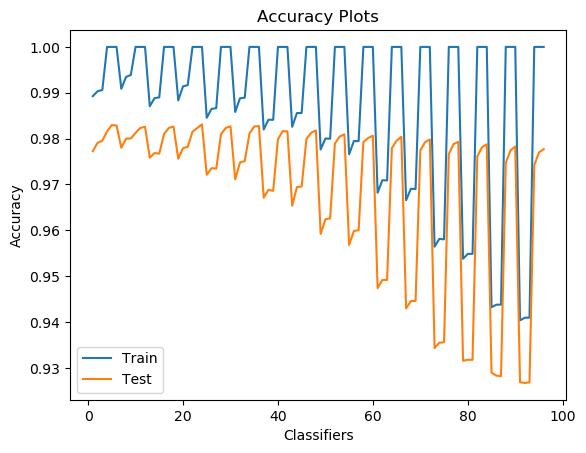

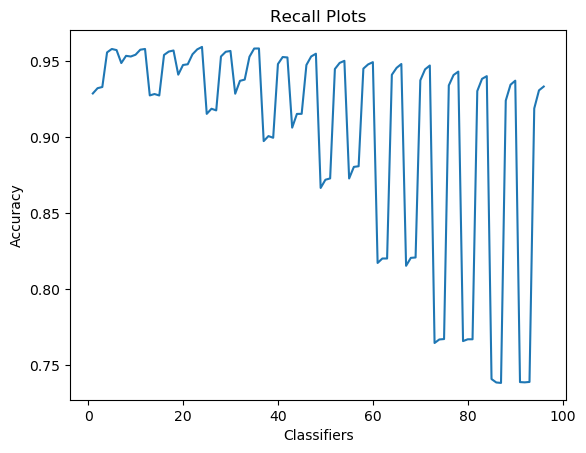

{'hyperparameters': 'n_neighbours: 7, weight: distance, distance_metric: 3', 'train_acc': 1.0, 'test_acc': 0.9831147453937238, 'recall_score': 0.9594066265969419, 'time': datetime.timedelta(microseconds=65576), 'confusion_matrix': array([[ 2209,    38,     1],
       [   32, 15106,   122],
       [    1,   124,  1200]])}


In [33]:
knn_classifier = knn_search(x_train3, y_train3.astype('int'), x_test3, y_test3.astype('int'))

In [34]:
save_model('saved_models/new_data_ica_models/', 'dtc.pkl', dtc_classifier)
save_model('saved_models/new_data_ica_models/', 'xgb.pkl', xgb_classifier)
save_model('saved_models/new_data_ica_models/', 'bag.pkl', bagging_classifier)
save_model('saved_models/new_data_ica_models/', 'rfc.pkl', rfc_classifier)
save_model('saved_models/new_data_ica_models/', 'gnb.pkl', gnb_classifier)
save_model('saved_models/new_data_ica_models/', 'knn.pkl', knn_classifier)

### ***Training Models (Outlying Values Cutted Off)***

In [60]:
data4 = pd.read_excel('generated_data/data_new.xlsx')
# data2 = data2.drop(columns=['timestamp', 'state'])

data_y4 = data4['Class']
data_x4 = data4.drop(columns=['Class'])

# labels = ['none', 'happy', 'frown']
labels = {'none': 0, 'happy': 1, 'frown': 2}

for i in range (len(data_y4)):
    data_y4.iloc[i] = labels[data_y4[i]]

x_train4, x_test4, y_train4, y_test4 = split(data_x4, data_y4, train_size=0.8)


DECISION TREE CLASSIFIER


Classifier 1.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: entropy
Train Accuray: 82.5155980353113% ..........  Test Accuracy: 82.10587798014124% ..........   Time Required:0:00:00.090459
Recall Score: 0.3610251878038003
Classifier 2.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: gini
Train Accuray: 82.5155980353113% ..........  Test Accuracy: 82.10587798014124% ..........   Time Required:0:00:00.083784
Recall Score: 0.3610251878038003
Classifier 3.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: log_loss
Train Accuray: 82.5155980353113% ..........  Test Accuracy: 82.10587798014124% ..........   Time Required:0:00:00.089946
Recall Score: 0.3610251878038003
Classifier 4.....
Hyperparameters... max_depth:2, min_samples_split:3, criterion: entropy
Train Accuray: 82.5155980353113% ..........  Test Accuracy: 82.10587798014124% ..........   Time Required:0:00:00.089527
Recall Score: 0.3610251878038003

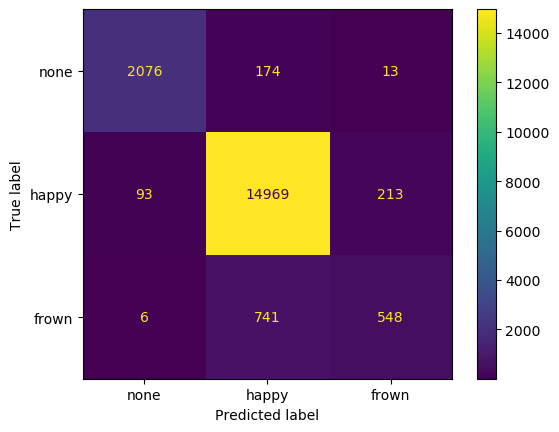

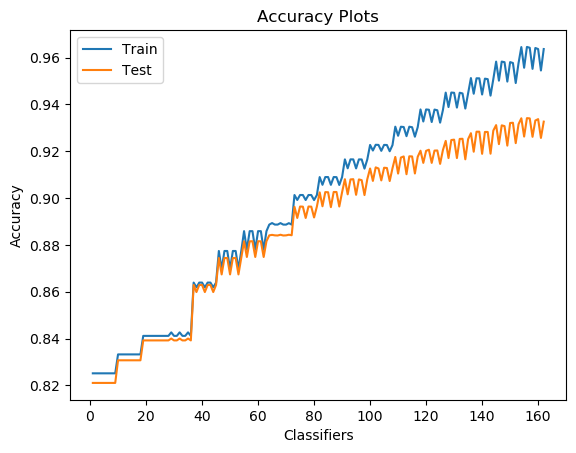

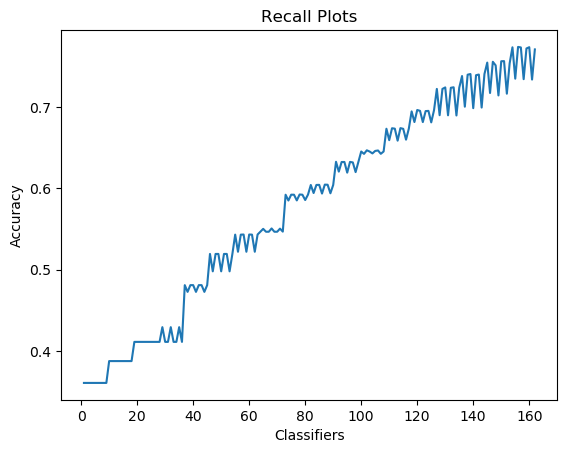

{'hyperparameters': 'max_depth: 19, min_samples_split: 2, criterion: log_loss', 'train_acc': 0.964582503650604, 'test_acc': 0.9341581266925079, 'recall_score': 0.7734998726083804, 'time': datetime.timedelta(microseconds=545091), 'confusion_matrix': array([[ 2076,   174,    13],
       [   93, 14969,   213],
       [    6,   741,   548]])}


In [61]:
dtc_classifier = dtc_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


XG Boost


Classifier 1.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.001
Train Accuray: 83.13686446302934% ..........  Test Accuracy: 82.85456379758934% ..........   Time Required:0:00:00.317334
Recall Score: 0.3817940786566505
Classifier 2.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.005
Train Accuray: 83.3174034249303% ..........  Test Accuracy: 83.05633728030585% ..........   Time Required:0:00:00.261592
Recall Score: 0.38751684333880815
Classifier 3.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.01
Train Accuray: 83.30014602416036% ..........  Test Accuracy: 83.04040779482823% ..........   Time Required:0:00:00.262382
Recall Score: 0.38732590194159755
Classifier 4.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.05
Train Accuray: 86.63480684986061% ..........  Test Accuracy: 86.45993734402379% ..........   Time Required:0:

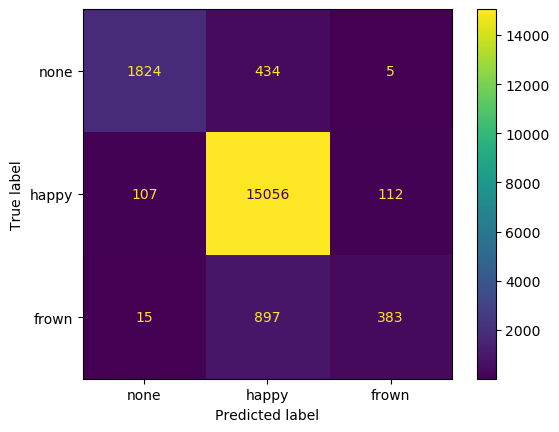

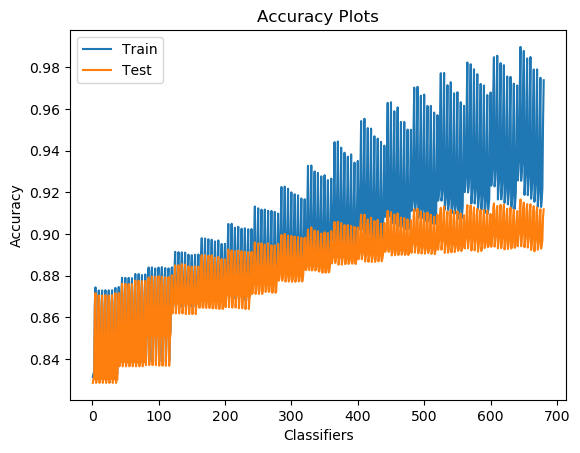

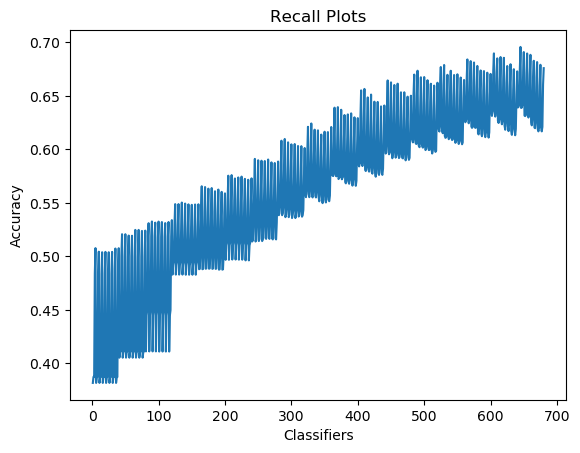

{'hyperparameters': 'max_depth:19, min_child_weight: 4, gamma: 0.0, learning_rate: 0.1', 'train_acc': 0.9898579583167397, 'test_acc': 0.9166356926671269, 'recall_score': 0.6958084883839625, 'time': datetime.timedelta(seconds=3, microseconds=723257), 'confusion_matrix': array([[ 1824,   434,     5],
       [  107, 15056,   112],
       [   15,   897,   383]])}


In [62]:
xgb_classifier = xgb_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


BAGGING CLASSIFIER


Classifier 1.....
Hyperparameters... n_estimators: 10
Train Accuray: 99.70927917164477% ..........  Test Accuracy: 94.63176339404237% ..........   Time Required:0:00:01.756818
Recall Score: 0.8027616899553042
Classifier 2.....
Hyperparameters... n_estimators: 15
Train Accuray: 99.87256073277578% ..........  Test Accuracy: 94.67955185047524% ..........   Time Required:0:00:01.789871
Recall Score: 0.8098409710628475
Classifier 3.....
Hyperparameters... n_estimators: 20
Train Accuray: 99.91504048851719% ..........  Test Accuracy: 94.7963680773111% ..........   Time Required:0:00:02.246277
Recall Score: 0.804367617863166
Classifier 4.....
Hyperparameters... n_estimators: 25
Train Accuray: 99.96814018319394% ..........  Test Accuracy: 95.08840864440079% ..........   Time Required:0:00:02.997625
Recall Score: 0.8216178910023458
Classifier 5.....
Hyperparameters... n_estimators: 30
Train Accuray: 99.96814018319394% ..........  Test Accuracy: 95.06716933043063% .......... 

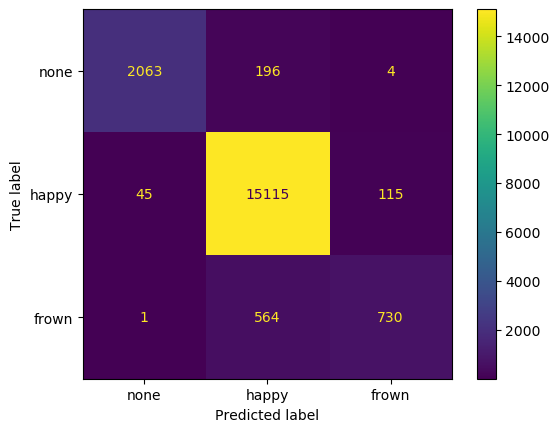

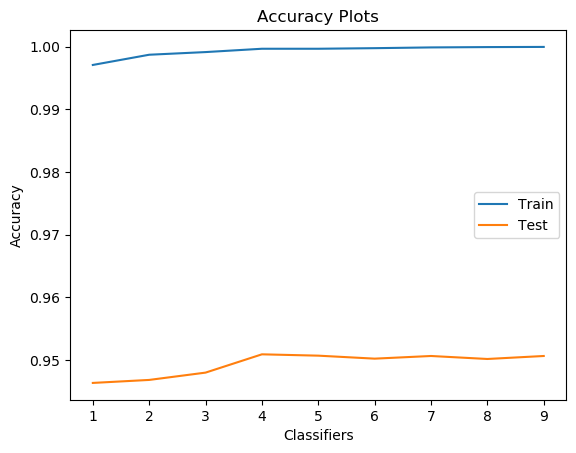

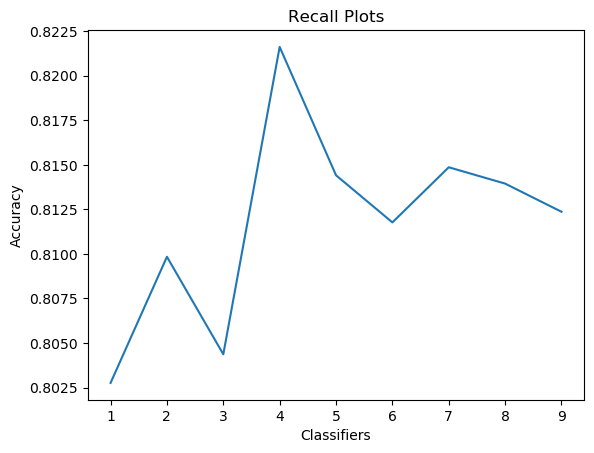

{'hyperparameters': 'n_estimators: 25', 'train_acc': 0.9996814018319394, 'test_acc': 0.9508840864440079, 'recall_score': 0.8216178910023458, 'time': datetime.timedelta(seconds=2, microseconds=997625), 'confusion_matrix': array([[ 2063,   196,     4],
       [   45, 15115,   115],
       [    1,   564,   730]])}


In [63]:
bagging_classifier = bagging_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


RANDOM FOREST CLASSIFIER


Classifier 1.....
Hyperparameters... n_estimators: 10
Train Accuray: 99.62166467542811% ..........  Test Accuracy: 92.90075930547444% ..........   Time Required:0:00:00.176716
Recall Score: 0.7284664263639641
Classifier 2.....
Hyperparameters... n_estimators: 14
Train Accuray: 99.78096375945839% ..........  Test Accuracy: 93.1237721021611% ..........   Time Required:0:00:00.194696
Recall Score: 0.7324608438347496
Classifier 3.....
Hyperparameters... n_estimators: 18
Train Accuray: 99.88849064117882% ..........  Test Accuracy: 93.34678489884777% ..........   Time Required:0:00:00.210831
Recall Score: 0.7373822019475972
Classifier 4.....
Hyperparameters... n_estimators: 22
Train Accuray: 99.92698791981947% ..........  Test Accuracy: 93.21403918653427% ..........   Time Required:0:00:00.238685
Recall Score: 0.7331160144845613
Classifier 5.....
Hyperparameters... n_estimators: 26
Train Accuray: 99.95752024425859% ..........  Test Accuracy: 93.26713747145968% ....

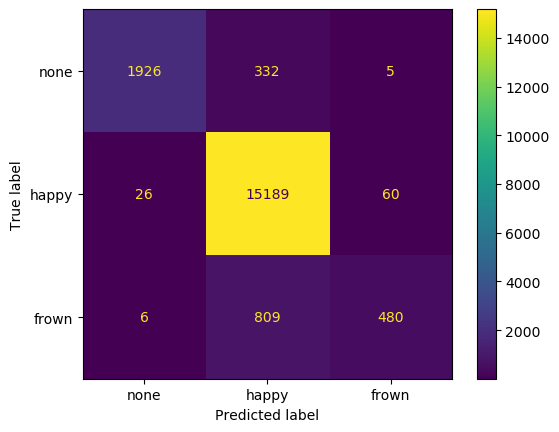

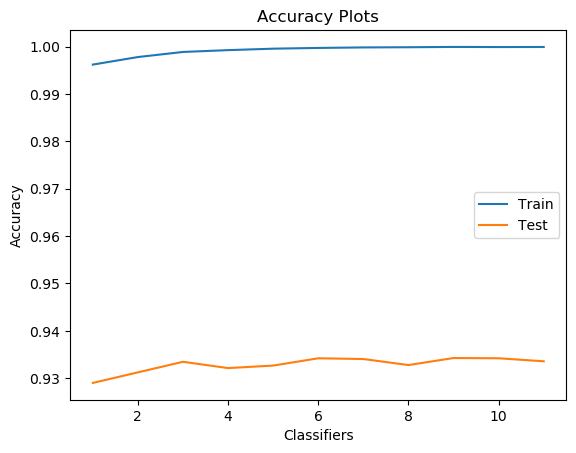

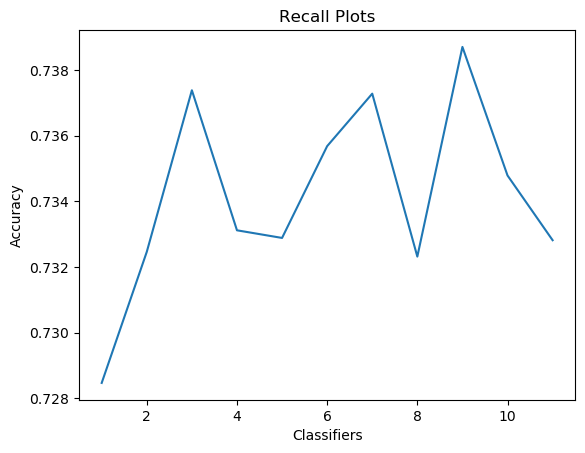

{'hyperparameters': 'n_estimators: 42', 'train_acc': 0.9999469003053233, 'test_acc': 0.9342643232623586, 'recall_score': 0.7387029632540676, 'time': datetime.timedelta(microseconds=283028), 'confusion_matrix': array([[ 1926,   332,     5],
       [   26, 15189,    60],
       [    6,   809,   480]])}


In [64]:
rfc_classifier = rfc_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


GAUSSAIN NAIVE BAYES


Classifier 1.....
Hyperparameters... var_smoothing: 1e-10
Train Accuray: 78.31010221691224% ..........  Test Accuracy: 77.70403015982585% ..........   Time Required:0:00:00.012084
Recall Score: 0.36457633223590663
Classifier 2.....
Hyperparameters... var_smoothing: 2e-10
Train Accuray: 79.73051904951546% ..........  Test Accuracy: 79.24919025115489% ..........   Time Required:0:00:00.009675
Recall Score: 0.35090243856201303
Classifier 3.....
Hyperparameters... var_smoothing: 3e-10
Train Accuray: 81.17084826762246% ..........  Test Accuracy: 80.6562948016779% ..........   Time Required:0:00:00.009590
Recall Score: 0.3361900127857575
Classifier 4.....
Hyperparameters... var_smoothing: 4e-10
Train Accuray: 81.51732377538829% ..........  Test Accuracy: 81.08639090957362% ..........   Time Required:0:00:00.009677
Recall Score: 0.3337172009512435
Classifier 5.....
Hyperparameters... var_smoothing: 5e-10
Train Accuray: 81.55051108456126% ..........  Test Accuracy: 81.11

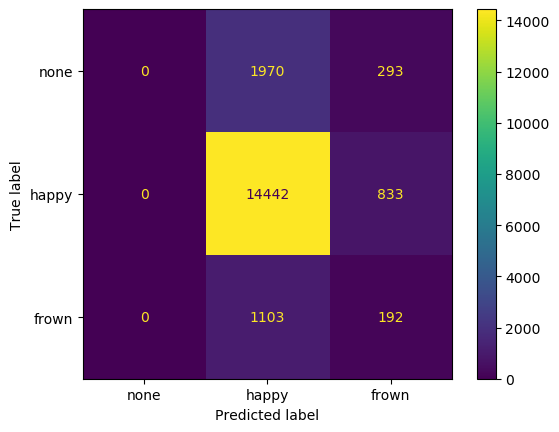

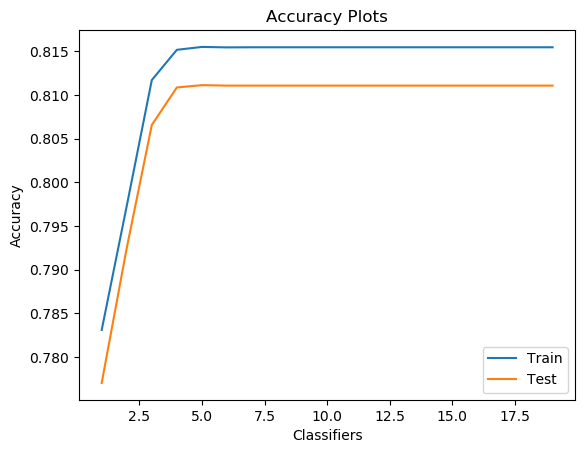

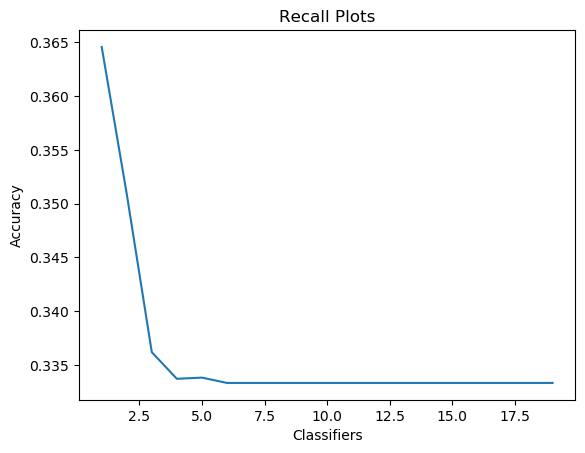

{'hyperparameters': 'var_smoothing: 1e-10', 'train_acc': 0.7831010221691225, 'test_acc': 0.7770403015982584, 'recall_score': 0.36457633223590663, 'time': datetime.timedelta(microseconds=12084), 'confusion_matrix': array([[    0,  1970,   293],
       [    0, 14442,   833],
       [    0,  1103,   192]])}


In [65]:
gnb_classifier = gnb_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


K NEAREST NEIGHBOURS


Classifier 1.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 1
Train Accuray: 98.9247311827957% ..........  Test Accuracy: 97.82828014655126% ..........   Time Required:0:00:00.063927
Recall Score: 0.9269077654023263
Classifier 2.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 2
Train Accuray: 99.03225806451613% ..........  Test Accuracy: 97.99819465831253% ..........   Time Required:0:00:00.061399
Recall Score: 0.9313267079117343
Classifier 3.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 3
Train Accuray: 99.05349794238684% ..........  Test Accuracy: 98.01412414379016% ..........   Time Required:0:00:00.062441
Recall Score: 0.9317532274168635
Classifier 4.....
Hyperparameters... n_neighbours: 4, weight: distance, distance_metric: 1
Train Accuray: 100.0% ..........  Test Accuracy: 98.36457282429778% ..........   Time Required:0:00:00.060705
Recall Score: 0.9594270201052763
Classifie

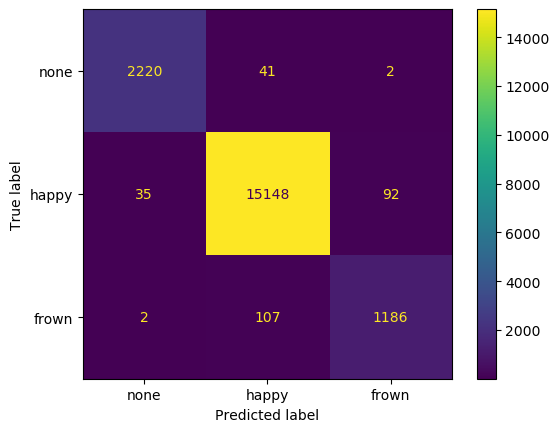

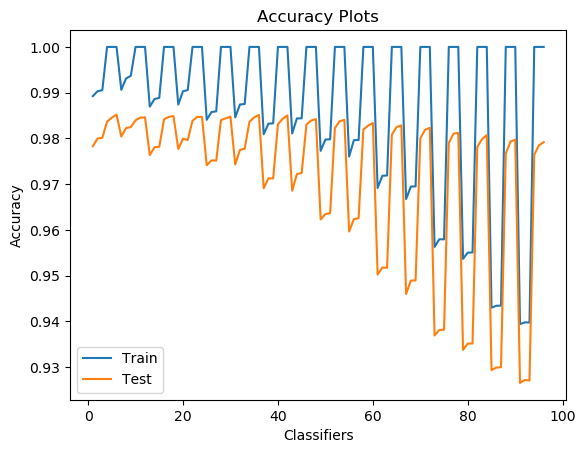

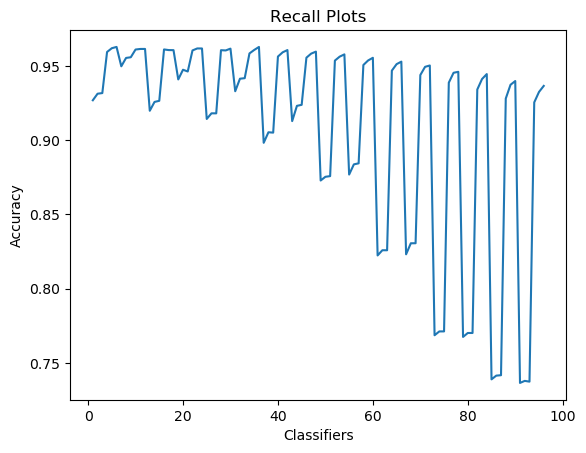

{'hyperparameters': 'n_neighbours: 4, weight: distance, distance_metric: 3', 'train_acc': 1.0, 'test_acc': 0.9851855785058142, 'recall_score': 0.962838183734565, 'time': datetime.timedelta(microseconds=64558), 'confusion_matrix': array([[ 2220,    41,     2],
       [   35, 15148,    92],
       [    2,   107,  1186]])}


In [66]:
knn_classifier = knn_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


In [67]:
save_model('saved_models/new_data2_models/', 'dtc.pkl', dtc_classifier)
save_model('saved_models/new_data2_models/', 'xgb.pkl', xgb_classifier)
save_model('saved_models/new_data2_models/', 'bag.pkl', bagging_classifier)
save_model('saved_models/new_data2_models/', 'rfc.pkl', rfc_classifier)
save_model('saved_models/new_data2_models/', 'gnb.pkl', gnb_classifier)
save_model('saved_models/new_data2_models/', 'knn.pkl', knn_classifier)

### ***Training Models (Outlying Values Cutted Off ICA)***

In [68]:
data4 = pd.read_excel('generated_data/data_new.xlsx')
# data2 = data2.drop(columns=['timestamp', 'state'])

data_y4 = data4['Class']
data_x4 = data4.drop(columns=['Class'])

# labels = ['none', 'happy', 'frown']
labels = {'none': 0, 'happy': 1, 'frown': 2}

for i in range (len(data_y4)):
    data_y4.iloc[i] = labels[data_y4[i]]

x_train4, x_test4, y_train4, y_test4 = split(data_x4, data_y4, train_size=0.8)


DECISION TREE CLASSIFIER


Classifier 1.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: entropy
Train Accuray: 82.46913580246914% ..........  Test Accuracy: 82.29172197738012% ..........   Time Required:0:00:00.089907
Recall Score: 0.36031254607106006
Classifier 2.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: gini
Train Accuray: 82.46913580246914% ..........  Test Accuracy: 82.29172197738012% ..........   Time Required:0:00:00.079858
Recall Score: 0.36031254607106006
Classifier 3.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: log_loss
Train Accuray: 82.46913580246914% ..........  Test Accuracy: 82.29172197738012% ..........   Time Required:0:00:00.089494
Recall Score: 0.36031254607106006
Classifier 4.....
Hyperparameters... max_depth:2, min_samples_split:3, criterion: entropy
Train Accuray: 82.46913580246914% ..........  Test Accuracy: 82.29172197738012% ..........   Time Required:0:00:00.087200
Recall Score: 0.360312546

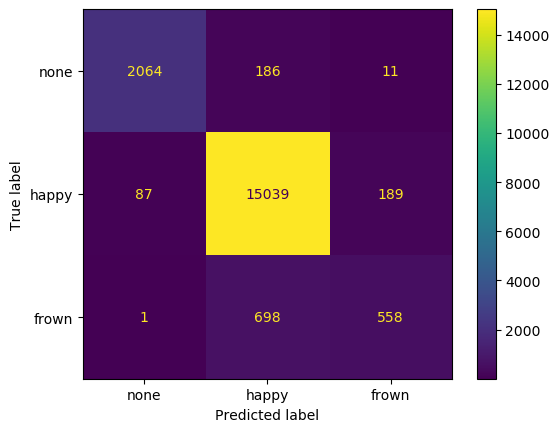

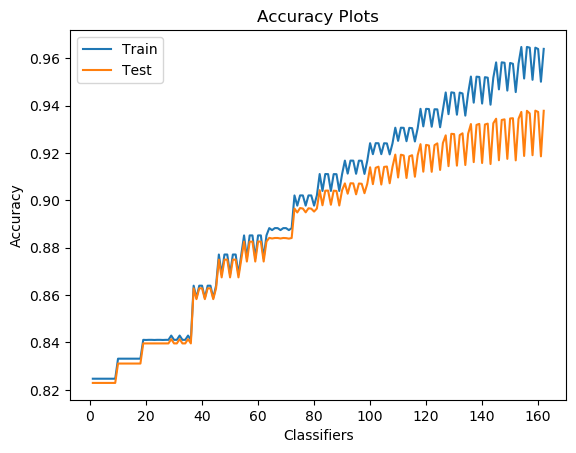

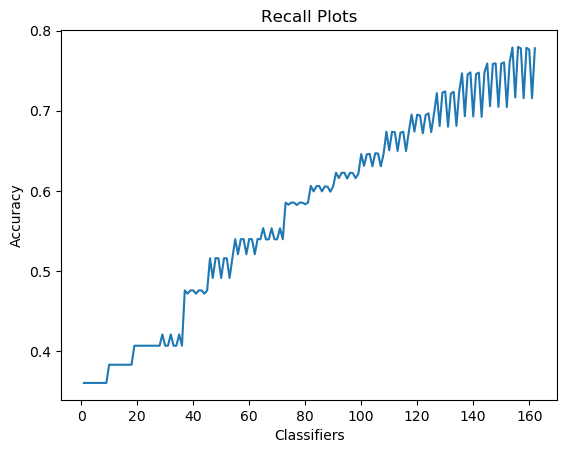

{'hyperparameters': 'max_depth: 19, min_samples_split: 2, criterion: log_loss', 'train_acc': 0.9647285278109651, 'test_acc': 0.9377688100674348, 'recall_score': 0.7795876483218533, 'time': datetime.timedelta(microseconds=541456), 'confusion_matrix': array([[ 2064,   186,    11],
       [   87, 15039,   189],
       [    1,   698,   558]])}


In [69]:
dtc_classifier = dtc_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


XG Boost


Classifier 1.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.001
Train Accuray: 83.08774724545333% ..........  Test Accuracy: 82.91297191100728% ..........   Time Required:0:00:00.316008
Recall Score: 0.3775615509361639
Classifier 2.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.005
Train Accuray: 83.2603212531528% ..........  Test Accuracy: 83.08288642276854% ..........   Time Required:0:00:00.255226
Recall Score: 0.3825305519565078
Classifier 3.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.01
Train Accuray: 83.2603212531528% ..........  Test Accuracy: 83.08288642276854% ..........   Time Required:0:00:00.256455
Recall Score: 0.3825305519565078
Classifier 4.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.05
Train Accuray: 86.02814283817868% ..........  Test Accuracy: 85.93426432326235% ..........   Time Required:0:00:

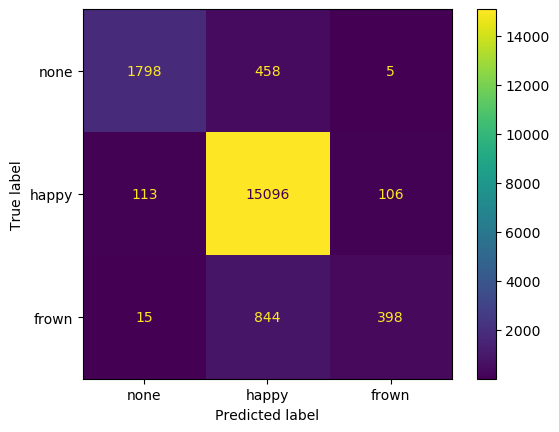

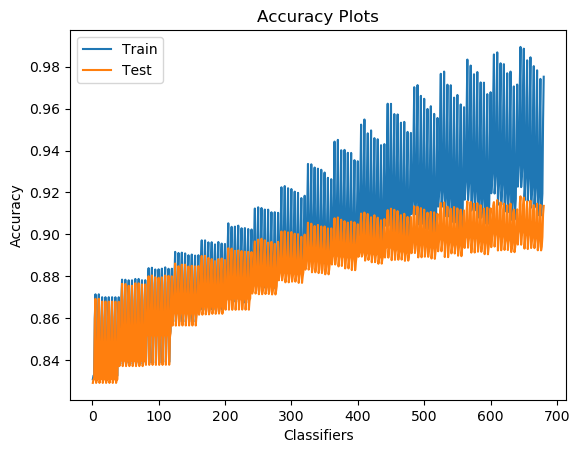

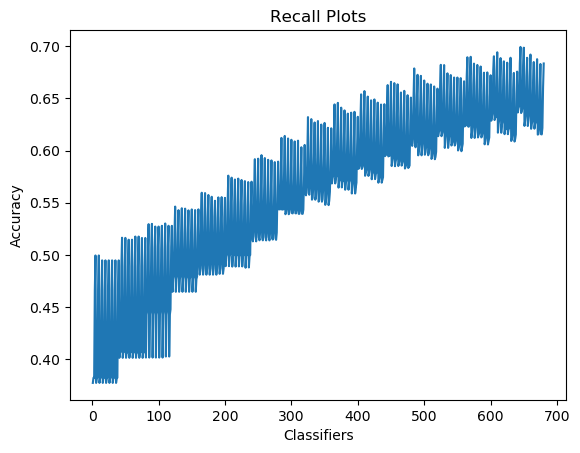

{'hyperparameters': 'max_depth:19, min_child_weight: 4, gamma: 0.0, learning_rate: 0.1', 'train_acc': 0.989459710606664, 'test_acc': 0.9181755429299634, 'recall_score': 0.6991835119159084, 'time': datetime.timedelta(seconds=3, microseconds=567984), 'confusion_matrix': array([[ 1798,   458,     5],
       [  113, 15096,   106],
       [   15,   844,   398]])}


In [70]:
xgb_classifier = xgb_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


BAGGING CLASSIFIER


Classifier 1.....
Hyperparameters... n_estimators: 10
Train Accuray: 99.70131421744325% ..........  Test Accuracy: 94.77512876334094% ..........   Time Required:0:00:01.759458
Recall Score: 0.808633642044728
Classifier 2.....
Hyperparameters... n_estimators: 15
Train Accuray: 99.8871631488119% ..........  Test Accuracy: 95.17336590028142% ..........   Time Required:0:00:01.788488
Recall Score: 0.8300056232148295
Classifier 3.....
Hyperparameters... n_estimators: 20
Train Accuray: 99.92433293508563% ..........  Test Accuracy: 95.14150692932618% ..........   Time Required:0:00:02.195869
Recall Score: 0.8193061846906994
Classifier 4.....
Hyperparameters... n_estimators: 25
Train Accuray: 99.96548519846012% ..........  Test Accuracy: 95.34328041204269% ..........   Time Required:0:00:02.998687
Recall Score: 0.829296965034016
Classifier 5.....
Hyperparameters... n_estimators: 30
Train Accuray: 99.97610513739545% ..........  Test Accuracy: 95.36982955450539% ..........  

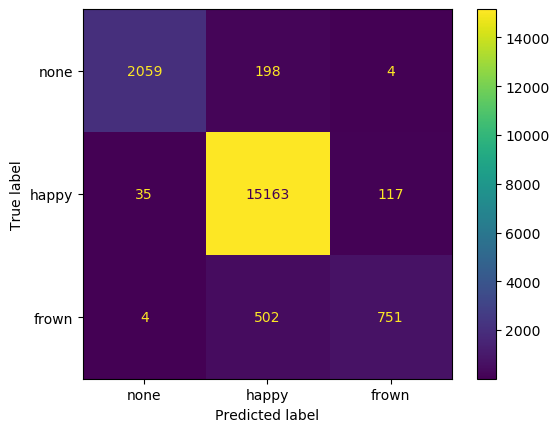

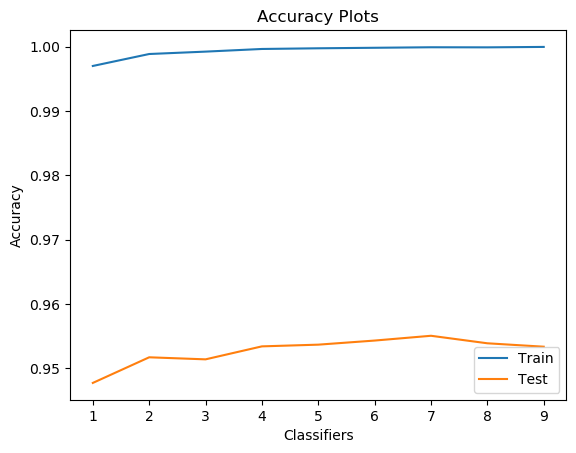

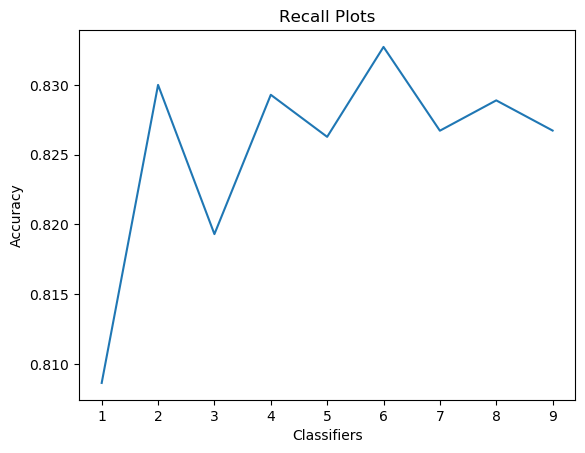

{'hyperparameters': 'n_estimators: 35', 'train_acc': 0.9998407009159698, 'test_acc': 0.9543354749641586, 'recall_score': 0.8327294487963385, 'time': datetime.timedelta(seconds=3, microseconds=756871), 'confusion_matrix': array([[ 2059,   198,     4],
       [   35, 15163,   117],
       [    4,   502,   751]])}


In [71]:
bagging_classifier = bagging_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


RANDOM FOREST CLASSIFIER


Classifier 1.....
Hyperparameters... n_estimators: 10
Train Accuray: 99.59511482808973% ..........  Test Accuracy: 93.19279987256411% ..........   Time Required:0:00:00.170775
Recall Score: 0.7410624399552254
Classifier 2.....
Hyperparameters... n_estimators: 14
Train Accuray: 99.78760122129297% ..........  Test Accuracy: 93.16094090160888% ..........   Time Required:0:00:00.179224
Recall Score: 0.7315871264373149
Classifier 3.....
Hyperparameters... n_estimators: 18
Train Accuray: 99.89645559538033% ..........  Test Accuracy: 93.41050284075824% ..........   Time Required:0:00:00.193976
Recall Score: 0.741263236233843
Classifier 4.....
Hyperparameters... n_estimators: 22
Train Accuray: 99.91902296561794% ..........  Test Accuracy: 93.64944512292253% ..........   Time Required:0:00:00.228793
Recall Score: 0.749168176312503
Classifier 5.....
Hyperparameters... n_estimators: 26
Train Accuray: 99.96283021372628% ..........  Test Accuracy: 93.70785323634047% .....

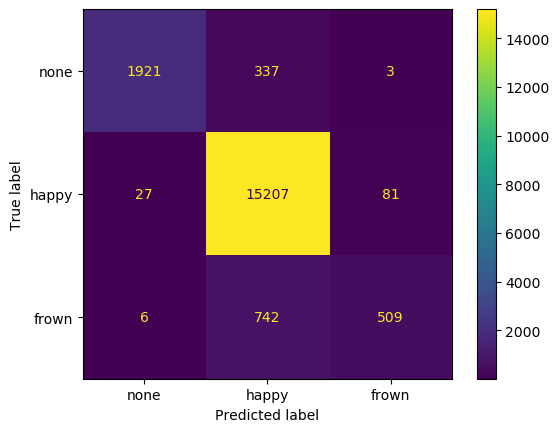

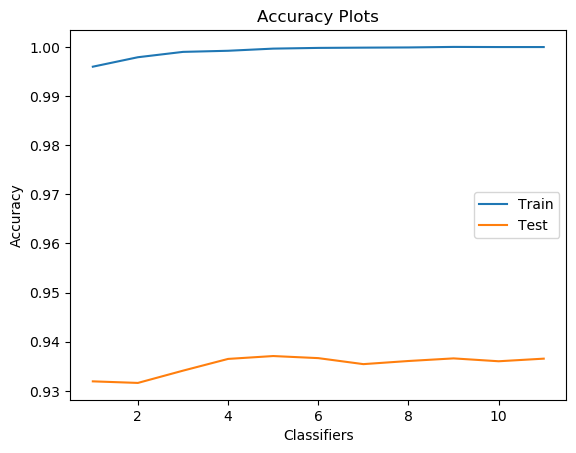

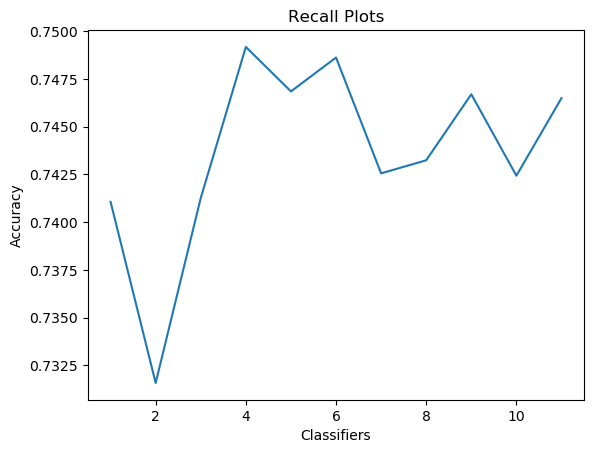

{'hyperparameters': 'n_estimators: 22', 'train_acc': 0.9991902296561794, 'test_acc': 0.9364944512292253, 'recall_score': 0.749168176312503, 'time': datetime.timedelta(microseconds=228793), 'confusion_matrix': array([[ 1921,   337,     3],
       [   27, 15207,    81],
       [    6,   742,   509]])}


In [72]:
rfc_classifier = rfc_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


GAUSSAIN NAIVE BAYES


Classifier 1.....
Hyperparameters... var_smoothing: 1e-10
Train Accuray: 78.62339041550511% ..........  Test Accuracy: 78.69696808793077% ..........   Time Required:0:00:00.012023
Recall Score: 0.36688314943336575
Classifier 2.....
Hyperparameters... var_smoothing: 2e-10
Train Accuray: 80.20708880923935% ..........  Test Accuracy: 80.12531195242394% ..........   Time Required:0:00:00.009501
Recall Score: 0.3462055778531507
Classifier 3.....
Hyperparameters... var_smoothing: 3e-10
Train Accuray: 81.37129961502721% ..........  Test Accuracy: 81.18727765093188% ..........   Time Required:0:00:00.009296
Recall Score: 0.3337628704653873
Classifier 4.....
Hyperparameters... var_smoothing: 4e-10
Train Accuray: 81.48679145094916% ..........  Test Accuracy: 81.33064302023044% ..........   Time Required:0:00:00.009445
Recall Score: 0.33410711312763447
Classifier 5.....
Hyperparameters... var_smoothing: 5e-10
Train Accuray: 81.4960838975176% ..........  Test Accuracy: 81.33

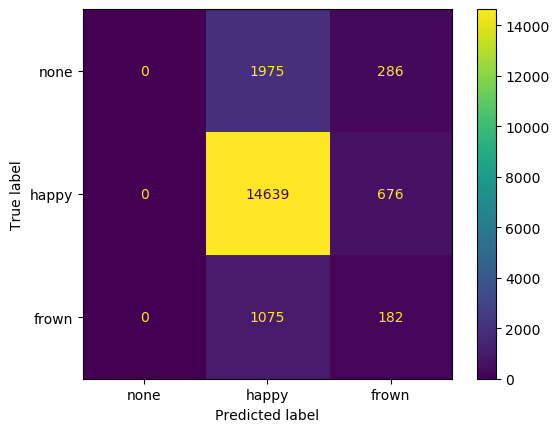

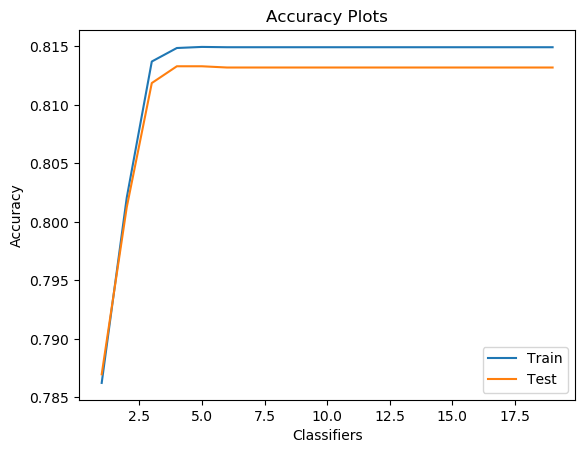

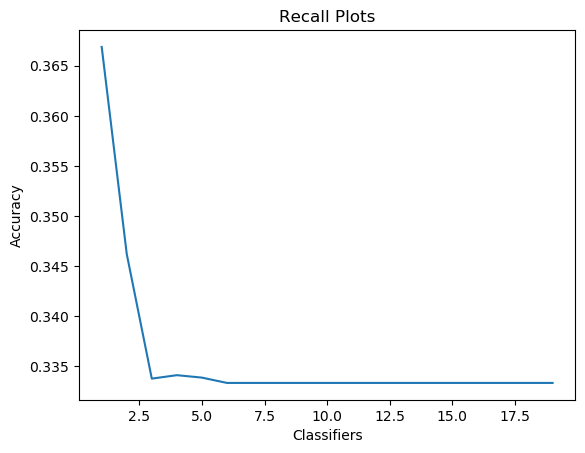

{'hyperparameters': 'var_smoothing: 1e-10', 'train_acc': 0.7862339041550511, 'test_acc': 0.7869696808793076, 'recall_score': 0.36688314943336575, 'time': datetime.timedelta(microseconds=12023), 'confusion_matrix': array([[    0,  1975,   286],
       [    0, 14639,   676],
       [    0,  1075,   182]])}


In [73]:
gnb_classifier = gnb_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


K NEAREST NEIGHBOURS


Classifier 1.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 1
Train Accuray: 98.9247311827957% ..........  Test Accuracy: 97.82828014655126% ..........   Time Required:0:00:00.062720
Recall Score: 0.9284293009618718
Classifier 2.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 2
Train Accuray: 99.01898314084694% ..........  Test Accuracy: 97.94509637338714% ..........   Time Required:0:00:00.065663
Recall Score: 0.9312561769690139
Classifier 3.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 3
Train Accuray: 99.03889552635073% ..........  Test Accuracy: 97.9663356873573% ..........   Time Required:0:00:00.062557
Recall Score: 0.9321991493093128
Classifier 4.....
Hyperparameters... n_neighbours: 4, weight: distance, distance_metric: 1
Train Accuray: 100.0% ..........  Test Accuracy: 98.27961556841714% ..........   Time Required:0:00:00.061666
Recall Score: 0.9584444806966882
Classifier

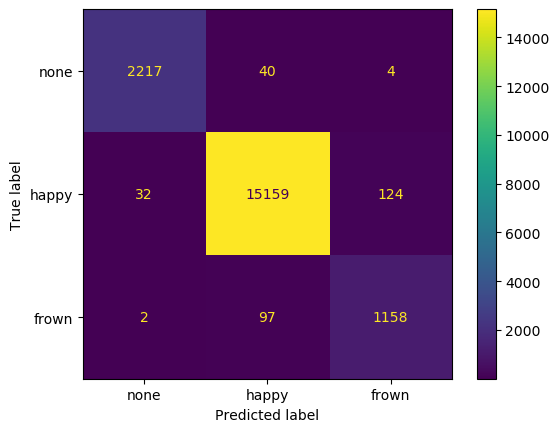

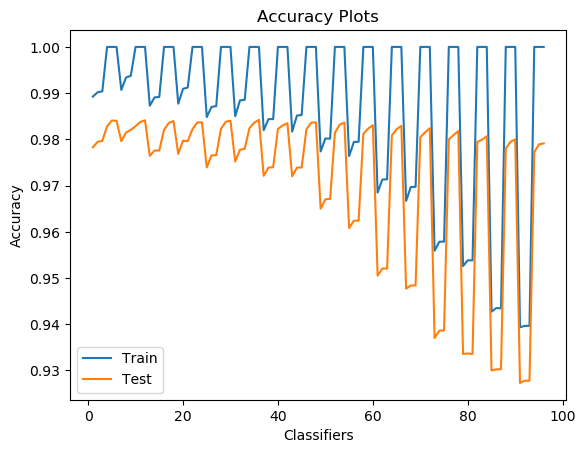

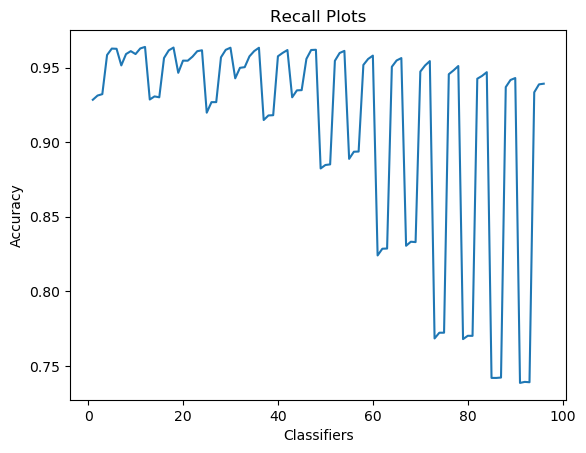

{'hyperparameters': 'n_neighbours: 5, weight: distance, distance_metric: 3', 'train_acc': 1.0, 'test_acc': 0.9841236128073063, 'recall_score': 0.9638648474358282, 'time': datetime.timedelta(microseconds=62626), 'confusion_matrix': array([[ 2217,    40,     4],
       [   32, 15159,   124],
       [    2,    97,  1158]])}


In [74]:
knn_classifier = knn_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


In [75]:
save_model('saved_models/new_data2_ica_models/', 'dtc.pkl', dtc_classifier)
save_model('saved_models/new_data2_ica_models/', 'xgb.pkl', xgb_classifier)
save_model('saved_models/new_data2_ica_models/', 'bag.pkl', bagging_classifier)
save_model('saved_models/new_data2_ica_models/', 'rfc.pkl', rfc_classifier)
save_model('saved_models/new_data2_ica_models/', 'gnb.pkl', gnb_classifier)
save_model('saved_models/new_data2_ica_models/', 'knn.pkl', knn_classifier)

### ***Training Models (Outlying Values Cutted Off PCA)***

In [76]:
data4 = pd.read_excel('generated_data/data_new.xlsx')
# data2 = data2.drop(columns=['timestamp', 'state'])

data_y4 = data4['Class']
data_x4 = data4.drop(columns=['Class'])

# labels = ['none', 'happy', 'frown']
labels = {'none': 0, 'happy': 1, 'frown': 2}

for i in range (len(data_y4)):
    data_y4.iloc[i] = labels[data_y4[i]]

x_train4, x_test4, y_train4, y_test4 = split(data_x4, data_y4, train_size=0.8)


DECISION TREE CLASSIFIER


Classifier 1.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: entropy
Train Accuray: 82.37753882915173% ..........  Test Accuracy: 82.65810014336536% ..........   Time Required:0:00:00.089154
Recall Score: 0.3558768656716418
Classifier 2.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: gini
Train Accuray: 82.37753882915173% ..........  Test Accuracy: 82.65810014336536% ..........   Time Required:0:00:00.079833
Recall Score: 0.3558768656716418
Classifier 3.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: log_loss
Train Accuray: 82.37753882915173% ..........  Test Accuracy: 82.65810014336536% ..........   Time Required:0:00:00.089135
Recall Score: 0.3558768656716418
Classifier 4.....
Hyperparameters... max_depth:2, min_samples_split:3, criterion: entropy
Train Accuray: 82.37753882915173% ..........  Test Accuracy: 82.65810014336536% ..........   Time Required:0:00:00.087977
Recall Score: 0.355876865671

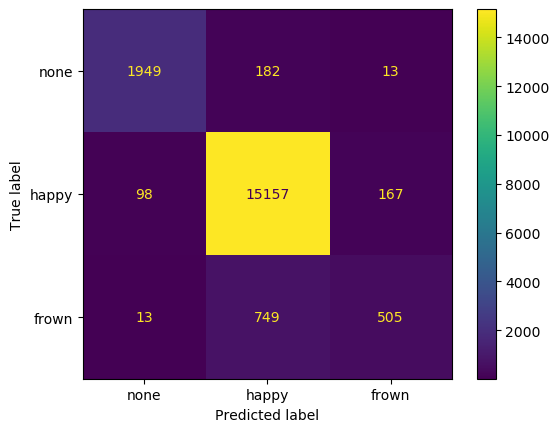

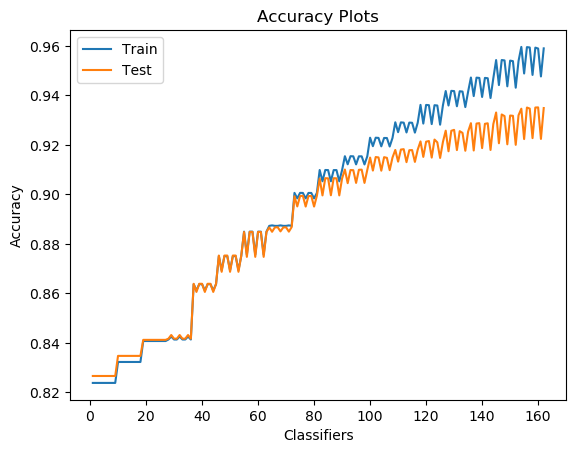

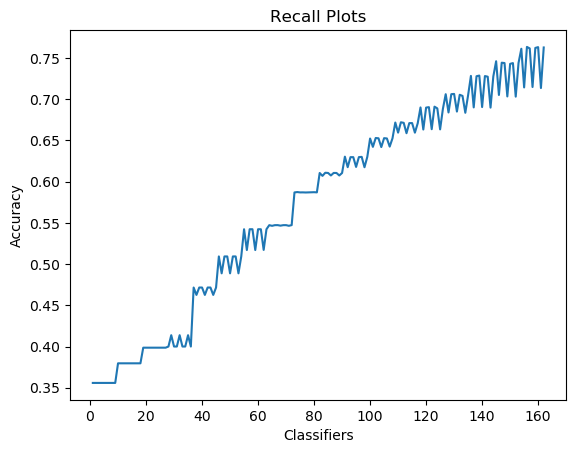

{'hyperparameters': 'max_depth: 19, min_samples_split: 2, criterion: log_loss', 'train_acc': 0.9595380326563122, 'test_acc': 0.935113895821165, 'recall_score': 0.7634815279928665, 'time': datetime.timedelta(microseconds=538402), 'confusion_matrix': array([[ 1949,   182,    13],
       [   98, 15157,   167],
       [   13,   749,   505]])}


In [77]:
dtc_classifier = dtc_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


XG Boost


Classifier 1.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.001
Train Accuray: 83.21385902031064% ..........  Test Accuracy: 83.45988424573886% ..........   Time Required:0:00:00.403183
Recall Score: 0.3796209508158856
Classifier 2.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.005
Train Accuray: 82.94305057745918% ..........  Test Accuracy: 83.15191419317156% ..........   Time Required:0:00:00.247656
Recall Score: 0.37836733044671594
Classifier 3.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.01
Train Accuray: 83.21253152794371% ..........  Test Accuracy: 83.45988424573886% ..........   Time Required:0:00:00.249658
Recall Score: 0.3796209508158856
Classifier 4.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.05
Train Accuray: 86.38391079251294% ..........  Test Accuracy: 86.61923219879998% ..........   Time Required:0:

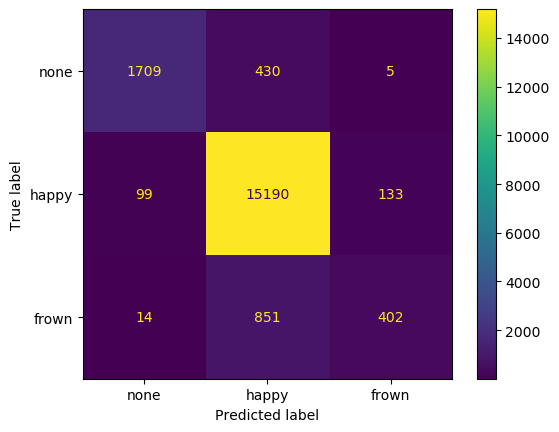

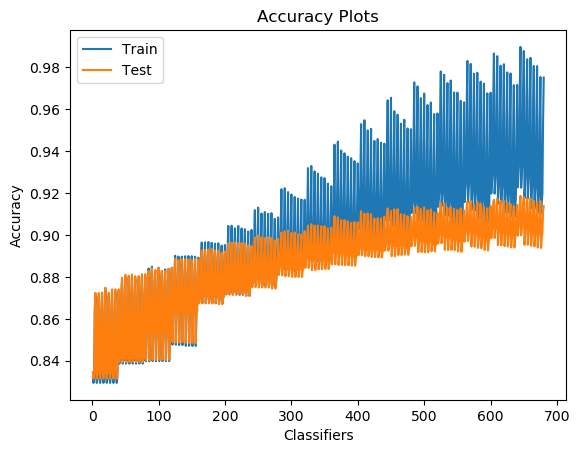

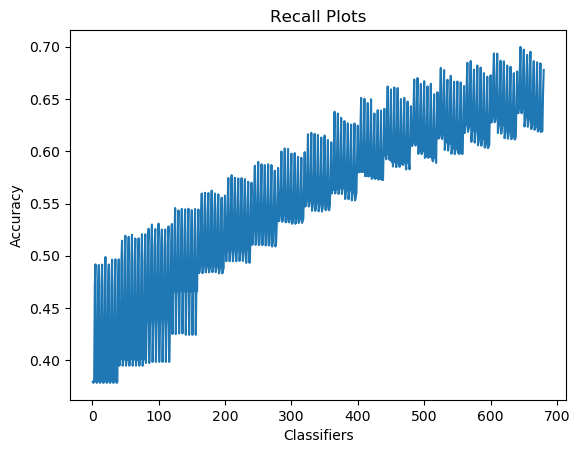

{'hyperparameters': 'max_depth:19, min_child_weight: 4, gamma: 0.0, learning_rate: 0.1', 'train_acc': 0.9896853843090402, 'test_acc': 0.9186534274942919, 'recall_score': 0.6997832298483068, 'time': datetime.timedelta(seconds=3, microseconds=444814), 'confusion_matrix': array([[ 1709,   430,     5],
       [   99, 15190,   133],
       [   14,   851,   402]])}


In [78]:
xgb_classifier = xgb_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


BAGGING CLASSIFIER


Classifier 1.....
Hyperparameters... n_estimators: 10
Train Accuray: 99.71591663347937% ..........  Test Accuracy: 94.75388944937079% ..........   Time Required:0:00:01.812583
Recall Score: 0.8086187152103945
Classifier 2.....
Hyperparameters... n_estimators: 15
Train Accuray: 99.87919819461038% ..........  Test Accuracy: 95.08309881590826% ..........   Time Required:0:00:01.798810
Recall Score: 0.8257911403773773
Classifier 3.....
Hyperparameters... n_estimators: 20
Train Accuray: 99.9230054427187% ..........  Test Accuracy: 95.02469070249032% ..........   Time Required:0:00:02.238498
Recall Score: 0.8169941606856641
Classifier 4.....
Hyperparameters... n_estimators: 25
Train Accuray: 99.96946767556086% ..........  Test Accuracy: 95.34859024053523% ..........   Time Required:0:00:03.055618
Recall Score: 0.8316252566686956
Classifier 5.....
Hyperparameters... n_estimators: 30
Train Accuray: 99.96681269082703% ..........  Test Accuracy: 95.18398555726651% ..........

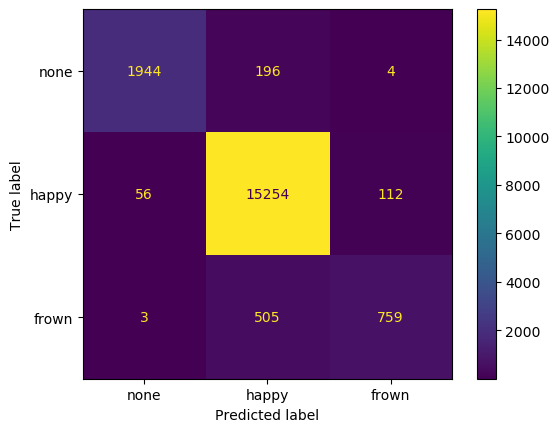

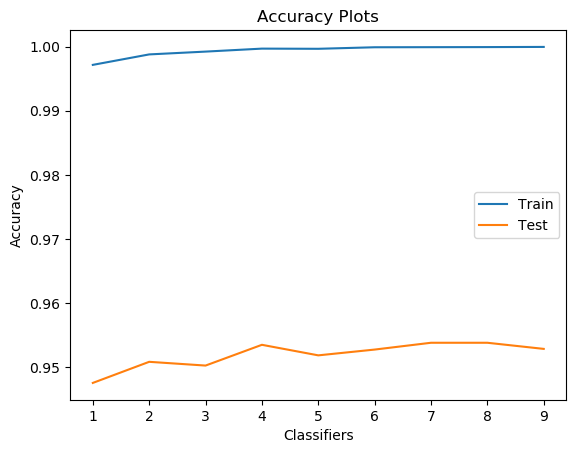

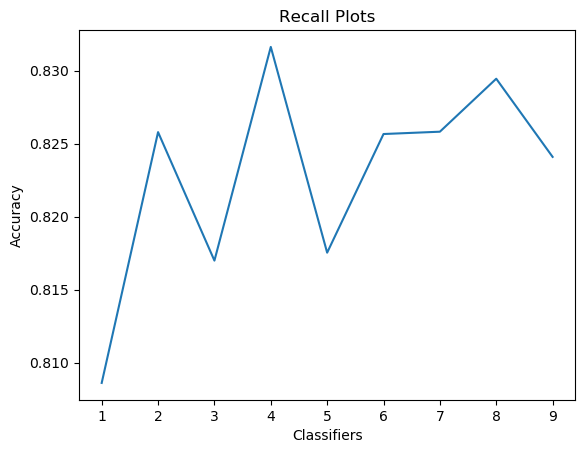

{'hyperparameters': 'n_estimators: 25', 'train_acc': 0.9996946767556086, 'test_acc': 0.9534859024053524, 'recall_score': 0.8316252566686956, 'time': datetime.timedelta(seconds=3, microseconds=55618), 'confusion_matrix': array([[ 1944,   196,     4],
       [   56, 15254,   112],
       [    3,   505,   759]])}


In [79]:
bagging_classifier = bagging_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


RANDOM FOREST CLASSIFIER


Classifier 1.....
Hyperparameters... n_estimators: 10
Train Accuray: 99.58183990442055% ..........  Test Accuracy: 93.18218021557904% ..........   Time Required:0:00:00.192837
Recall Score: 0.7375165616894345
Classifier 2.....
Hyperparameters... n_estimators: 14
Train Accuray: 99.79423868312757% ..........  Test Accuracy: 93.61227632347476% ..........   Time Required:0:00:00.181148
Recall Score: 0.7487897833979659
Classifier 3.....
Hyperparameters... n_estimators: 18
Train Accuray: 99.89247311827957% ..........  Test Accuracy: 93.62289598045983% ..........   Time Required:0:00:00.205163
Recall Score: 0.7455888730971546
Classifier 4.....
Hyperparameters... n_estimators: 22
Train Accuray: 99.94557281295633% ..........  Test Accuracy: 93.71316306483301% ..........   Time Required:0:00:00.228065
Recall Score: 0.7478618672143914
Classifier 5.....
Hyperparameters... n_estimators: 26
Train Accuray: 99.96415770609319% ..........  Test Accuracy: 93.62820580895237% ...

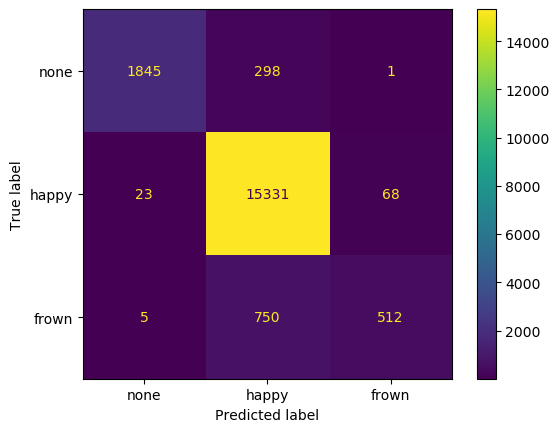

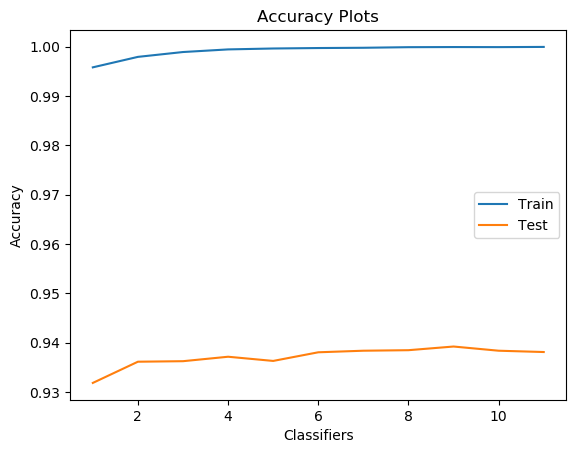

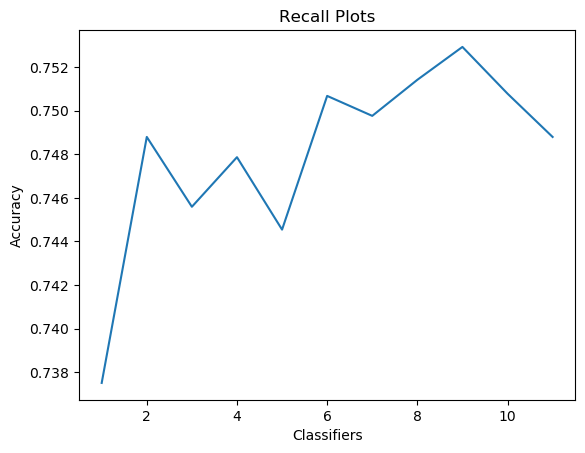

{'hyperparameters': 'n_estimators: 42', 'train_acc': 0.9999336253816541, 'test_acc': 0.9392024637604205, 'recall_score': 0.7529148554976707, 'time': datetime.timedelta(microseconds=311160), 'confusion_matrix': array([[ 1845,   298,     1],
       [   23, 15331,    68],
       [    5,   750,   512]])}


In [80]:
rfc_classifier = rfc_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


GAUSSAIN NAIVE BAYES


Classifier 1.....
Hyperparameters... var_smoothing: 1e-10
Train Accuray: 78.24107261383247% ..........  Test Accuracy: 78.84033345722933% ..........   Time Required:0:00:00.013477
Recall Score: 0.3660825491083764
Classifier 2.....
Hyperparameters... var_smoothing: 2e-10
Train Accuray: 79.73715651135007% ..........  Test Accuracy: 80.54478840333458% ..........   Time Required:0:00:00.009697
Recall Score: 0.3438022729208959
Classifier 3.....
Hyperparameters... var_smoothing: 3e-10
Train Accuray: 81.07925129430505% ..........  Test Accuracy: 81.72888015717092% ..........   Time Required:0:00:00.009484
Recall Score: 0.3372729248195236
Classifier 4.....
Hyperparameters... var_smoothing: 4e-10
Train Accuray: 81.34076729058808% ..........  Test Accuracy: 81.85100621249933% ..........   Time Required:0:00:00.009504
Recall Score: 0.3341479323895919
Classifier 5.....
Hyperparameters... var_smoothing: 5e-10
Train Accuray: 81.35404221425728% ..........  Test Accuracy: 81.893

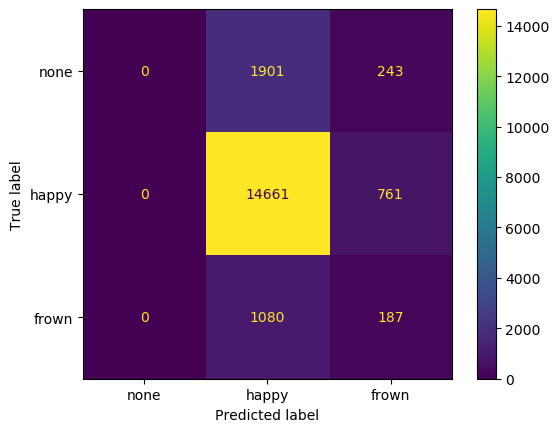

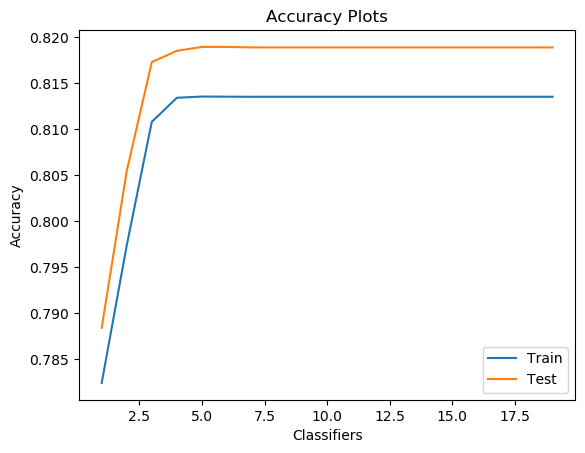

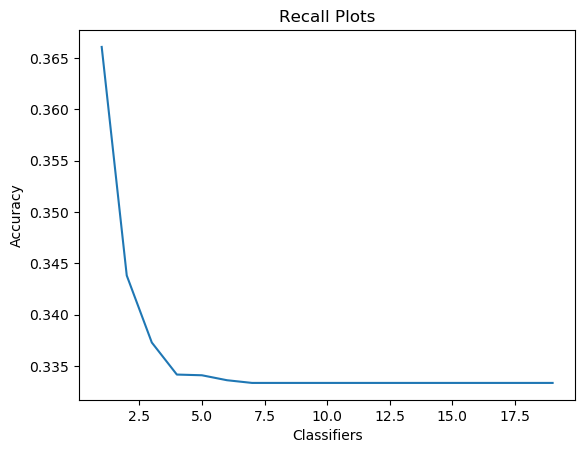

{'hyperparameters': 'var_smoothing: 1e-10', 'train_acc': 0.7824107261383247, 'test_acc': 0.7884033345722933, 'recall_score': 0.3660825491083764, 'time': datetime.timedelta(microseconds=13477), 'confusion_matrix': array([[    0,  1901,   243],
       [    0, 14661,   761],
       [    0,  1080,   187]])}


In [81]:
gnb_classifier = gnb_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


K NEAREST NEIGHBOURS


Classifier 1.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 1
Train Accuray: 98.93402362936413% ..........  Test Accuracy: 97.69022460574523% ..........   Time Required:0:00:00.063153
Recall Score: 0.927552048235158
Classifier 2.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 2
Train Accuray: 99.06411788132218% ..........  Test Accuracy: 97.8601391175065% ..........   Time Required:0:00:00.060400
Recall Score: 0.930844789447892
Classifier 3.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 3
Train Accuray: 99.07473782025752% ..........  Test Accuracy: 97.88137843147666% ..........   Time Required:0:00:00.060771
Recall Score: 0.9311727205416588
Classifier 4.....
Hyperparameters... n_neighbours: 4, weight: distance, distance_metric: 1
Train Accuray: 100.0% ..........  Test Accuracy: 98.19996814102905% ..........   Time Required:0:00:00.061917
Recall Score: 0.9597378855555103
Classifier 

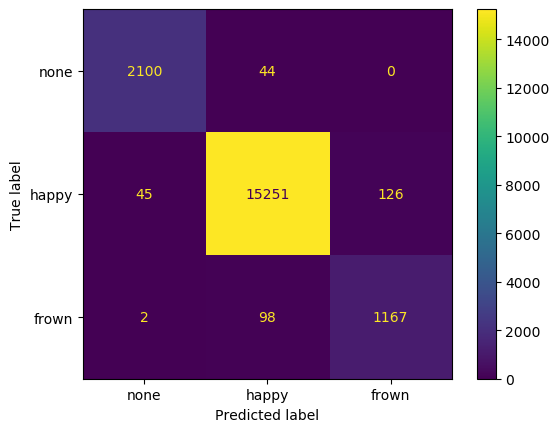

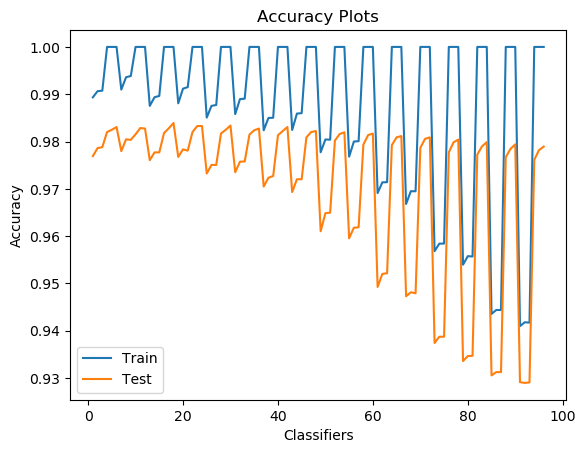

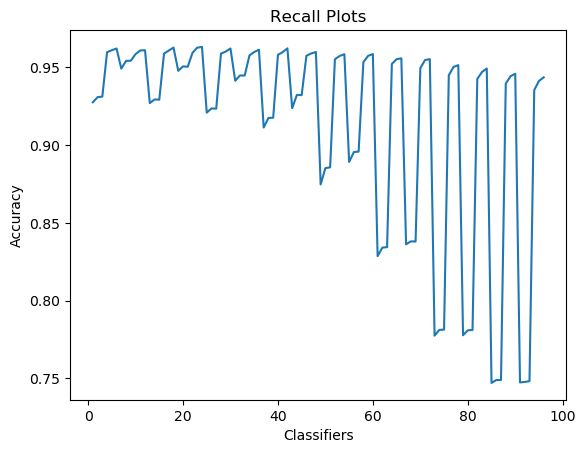

{'hyperparameters': 'n_neighbours: 7, weight: distance, distance_metric: 3', 'train_acc': 1.0, 'test_acc': 0.9832740402485, 'recall_score': 0.9631543192176073, 'time': datetime.timedelta(microseconds=64981), 'confusion_matrix': array([[ 2100,    44,     0],
       [   45, 15251,   126],
       [    2,    98,  1167]])}


In [82]:
knn_classifier = knn_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


In [83]:
save_model('saved_models/new_data2_pca_models/', 'dtc.pkl', dtc_classifier)
save_model('saved_models/new_data2_pca_models/', 'xgb.pkl', xgb_classifier)
save_model('saved_models/new_data2_pca_models/', 'bag.pkl', bagging_classifier)
save_model('saved_models/new_data2_pca_models/', 'rfc.pkl', rfc_classifier)
save_model('saved_models/new_data2_pca_models/', 'gnb.pkl', gnb_classifier)
save_model('saved_models/new_data2_pca_models/', 'knn.pkl', knn_classifier)

### ***Training Models (Outlying Values Cutted Off LDA)***

In [84]:
data4 = pd.read_excel('generated_data/data_new.xlsx')
# data2 = data2.drop(columns=['timestamp', 'state'])

data_y4 = data4['Class']
data_x4 = data4.drop(columns=['Class'])

# labels = ['none', 'happy', 'frown']
labels = {'none': 0, 'happy': 1, 'frown': 2}

for i in range (len(data_y4)):
    data_y4.iloc[i] = labels[data_y4[i]]

x_train4, x_test4, y_train4, y_test4 = split(data_x4, data_y4, train_size=0.8)


DECISION TREE CLASSIFIER


Classifier 1.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: entropy
Train Accuray: 82.39745121465552% ..........  Test Accuracy: 82.57845271597726% ..........   Time Required:0:00:00.091275
Recall Score: 0.36136502132845827
Classifier 2.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: gini
Train Accuray: 82.39745121465552% ..........  Test Accuracy: 82.57845271597726% ..........   Time Required:0:00:00.080809
Recall Score: 0.36136502132845827
Classifier 3.....
Hyperparameters... max_depth:2, min_samples_split:2, criterion: log_loss
Train Accuray: 82.39745121465552% ..........  Test Accuracy: 82.57845271597726% ..........   Time Required:0:00:00.087963
Recall Score: 0.36136502132845827
Classifier 4.....
Hyperparameters... max_depth:2, min_samples_split:3, criterion: entropy
Train Accuray: 82.39745121465552% ..........  Test Accuracy: 82.57845271597726% ..........   Time Required:0:00:00.089293
Recall Score: 0.361365021

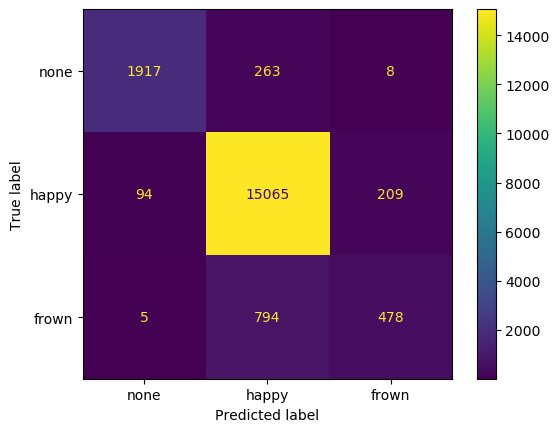

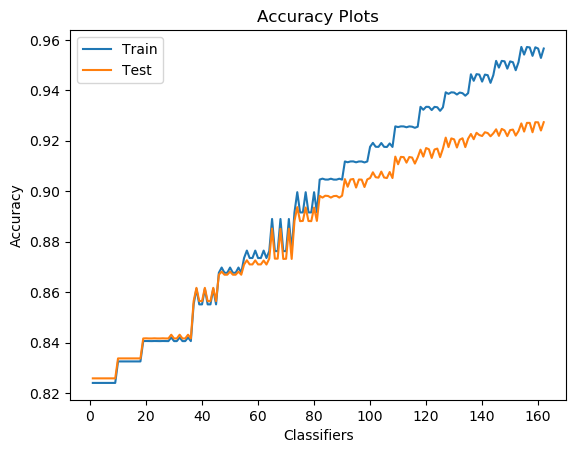

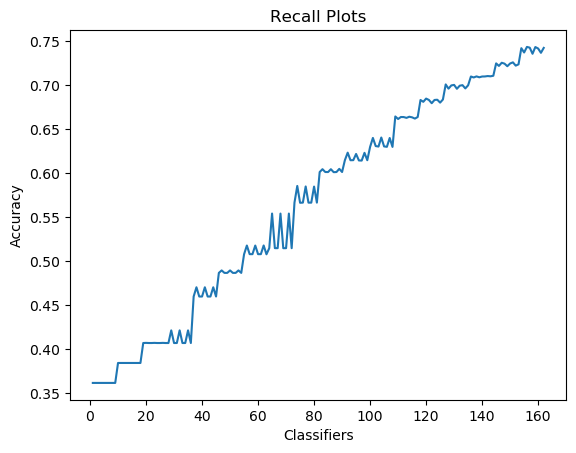

{'hyperparameters': 'max_depth: 19, min_samples_split: 2, criterion: log_loss', 'train_acc': 0.9571883711668658, 'test_acc': 0.9270960547974301, 'recall_score': 0.7435803675647371, 'time': datetime.timedelta(microseconds=568895), 'confusion_matrix': array([[ 1917,   263,     8],
       [   94, 15065,   209],
       [    5,   794,   478]])}


In [85]:
dtc_classifier = dtc_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


XG Boost


Classifier 1.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.001
Train Accuray: 83.03597504314351% ..........  Test Accuracy: 83.14129453618648% ..........   Time Required:0:00:00.278832
Recall Score: 0.37751371115173676
Classifier 2.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.005
Train Accuray: 83.11960706225939% ..........  Test Accuracy: 83.25280093452982% ..........   Time Required:0:00:00.246298
Recall Score: 0.382542164428503
Classifier 3.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.01
Train Accuray: 83.20191158900836% ..........  Test Accuracy: 83.3165188764403% ..........   Time Required:0:00:00.233149
Recall Score: 0.38280244553209486
Classifier 4.....
Hyperparameters... max_depth:3, min_child_weight: 4, gamma: 0.0, learning_rate: 0.05
Train Accuray: 86.54851984601089% ..........  Test Accuracy: 86.52365528593427% ..........   Time Required:0:0

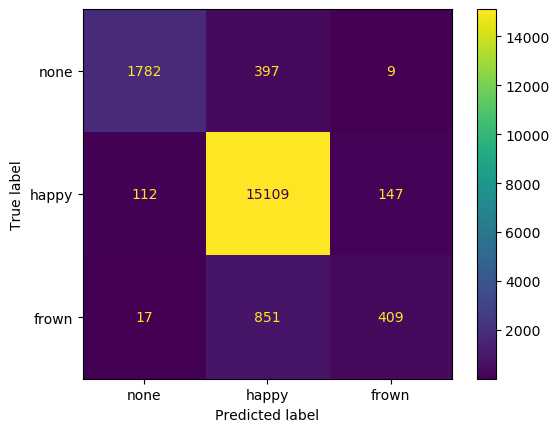

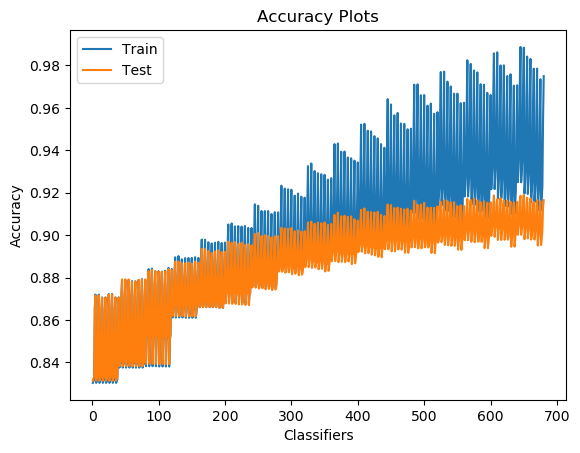

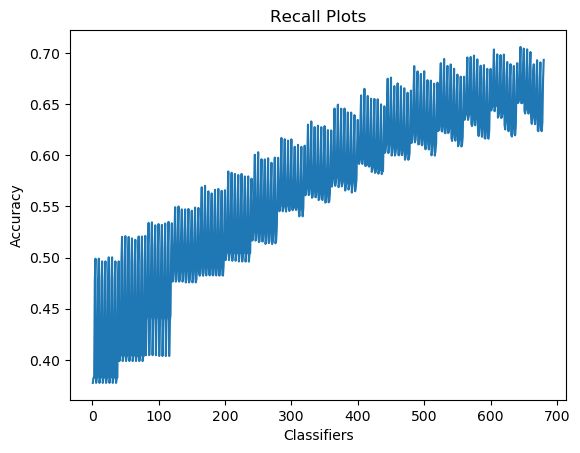

{'hyperparameters': 'max_depth:19, min_child_weight: 4, gamma: 0.0, learning_rate: 0.1', 'train_acc': 0.988756139652197, 'test_acc': 0.9186003292093665, 'recall_score': 0.7059570408111336, 'time': datetime.timedelta(seconds=3, microseconds=342583), 'confusion_matrix': array([[ 1782,   397,     9],
       [  112, 15109,   147],
       [   17,   851,   409]])}


In [86]:
xgb_classifier = xgb_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


BAGGING CLASSIFIER


Classifier 1.....
Hyperparameters... n_estimators: 10
Train Accuray: 99.70927917164477% ..........  Test Accuracy: 94.7698189348484% ..........   Time Required:0:00:01.824423
Recall Score: 0.8122297989690116
Classifier 2.....
Hyperparameters... n_estimators: 15
Train Accuray: 99.90043807248108% ..........  Test Accuracy: 95.12557744384857% ..........   Time Required:0:00:01.801806
Recall Score: 0.8320253802562064
Classifier 3.....
Hyperparameters... n_estimators: 20
Train Accuray: 99.91769547325103% ..........  Test Accuracy: 95.1308872723411% ..........   Time Required:0:00:02.216032
Recall Score: 0.8223209061875694
Classifier 4.....
Hyperparameters... n_estimators: 25
Train Accuray: 99.96681269082703% ..........  Test Accuracy: 95.30611161259492% ..........   Time Required:0:00:03.004476
Recall Score: 0.832197458057836
Classifier 5.....
Hyperparameters... n_estimators: 30
Train Accuray: 99.96415770609319% ..........  Test Accuracy: 95.0777889874157% ..........   

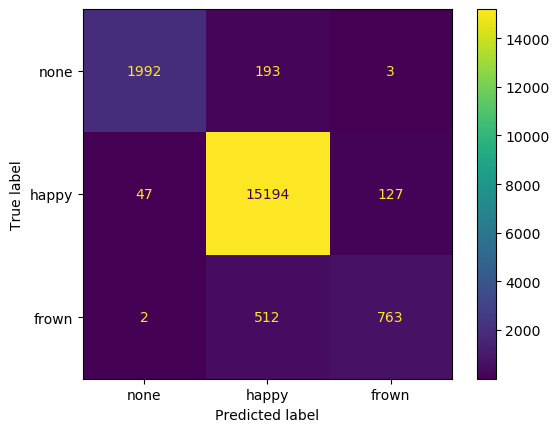

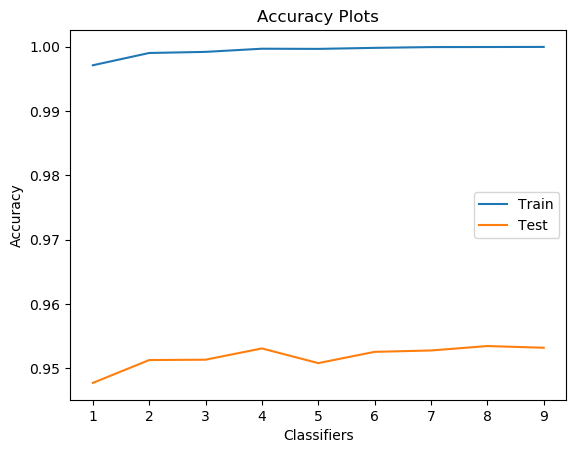

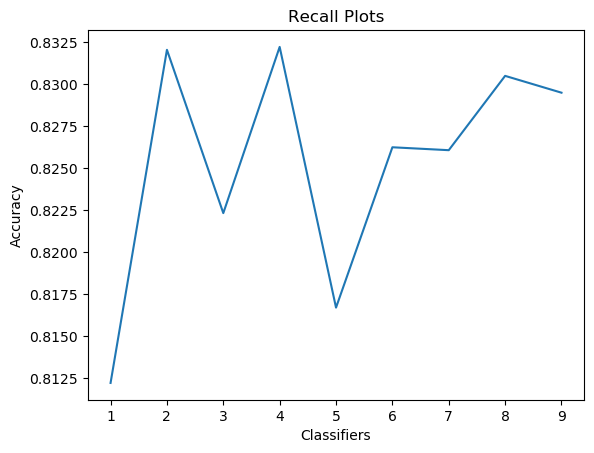

{'hyperparameters': 'n_estimators: 25', 'train_acc': 0.9996681269082702, 'test_acc': 0.9530611161259491, 'recall_score': 0.832197458057836, 'time': datetime.timedelta(seconds=3, microseconds=4476), 'confusion_matrix': array([[ 1992,   193,     3],
       [   47, 15194,   127],
       [    2,   512,   763]])}


In [87]:
bagging_classifier = bagging_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


RANDOM FOREST CLASSIFIER


Classifier 1.....
Hyperparameters... n_estimators: 10
Train Accuray: 99.58449488915439% ..........  Test Accuracy: 92.76801359316093% ..........   Time Required:0:00:00.186136
Recall Score: 0.726470796752608
Classifier 2.....
Hyperparameters... n_estimators: 14
Train Accuray: 99.78096375945839% ..........  Test Accuracy: 93.32554558487762% ..........   Time Required:0:00:00.187058
Recall Score: 0.7456337839190029
Classifier 3.....
Hyperparameters... n_estimators: 18
Train Accuray: 99.87919819461038% ..........  Test Accuracy: 93.31492592789253% ..........   Time Required:0:00:00.186398
Recall Score: 0.7411932321235851
Classifier 4.....
Hyperparameters... n_estimators: 22
Train Accuray: 99.93362538165405% ..........  Test Accuracy: 93.42643232623587% ..........   Time Required:0:00:00.231811
Recall Score: 0.7420199047155019
Classifier 5.....
Hyperparameters... n_estimators: 26
Train Accuray: 99.96150272135935% ..........  Test Accuracy: 93.378643869803% ......

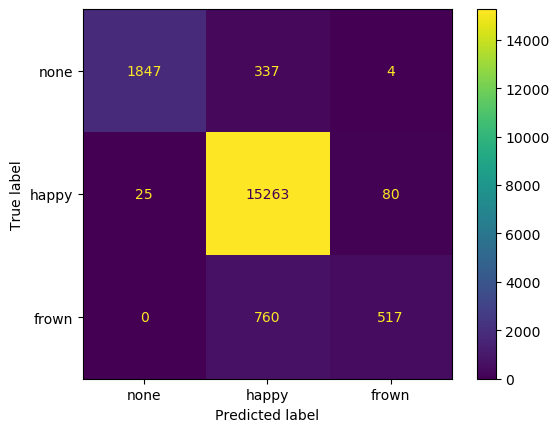

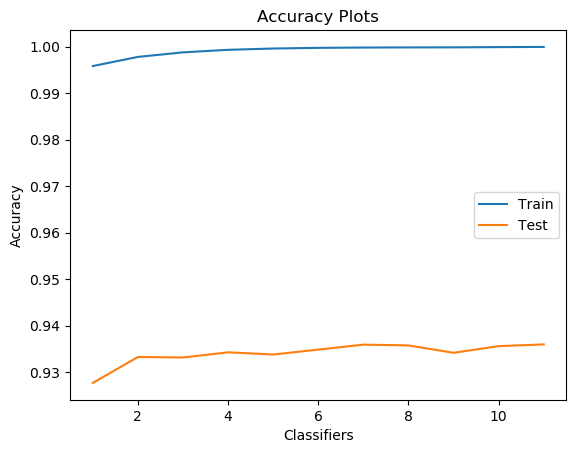

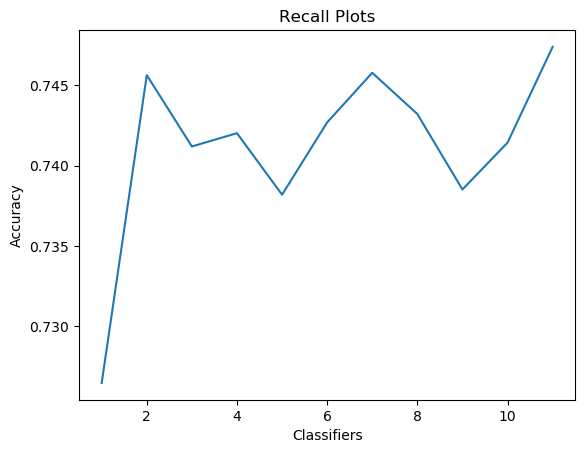

{'hyperparameters': 'n_estimators: 50', 'train_acc': 0.9999601752289924, 'test_acc': 0.9359634683799714, 'recall_score': 0.7473908862773729, 'time': datetime.timedelta(microseconds=329221), 'confusion_matrix': array([[ 1847,   337,     4],
       [   25, 15263,    80],
       [    0,   760,   517]])}


In [88]:
rfc_classifier = rfc_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


GAUSSAIN NAIVE BAYES


Classifier 1.....
Hyperparameters... var_smoothing: 1e-10
Train Accuray: 78.66985264834727% ..........  Test Accuracy: 79.0898953963787% ..........   Time Required:0:00:00.011299
Recall Score: 0.36687283973817797
Classifier 2.....
Hyperparameters... var_smoothing: 2e-10
Train Accuray: 80.16991902296562% ..........  Test Accuracy: 80.3217756066479% ..........   Time Required:0:00:00.009994
Recall Score: 0.34438102965872947
Classifier 3.....
Hyperparameters... var_smoothing: 3e-10
Train Accuray: 81.27041019514138% ..........  Test Accuracy: 81.46338873254393% ..........   Time Required:0:00:00.010063
Recall Score: 0.33468409782329994
Classifier 4.....
Hyperparameters... var_smoothing: 4e-10
Train Accuray: 81.41112438603479% ..........  Test Accuracy: 81.61206393033505% ..........   Time Required:0:00:00.010061
Recall Score: 0.3340947285976712
Classifier 5.....
Hyperparameters... var_smoothing: 5e-10
Train Accuray: 81.42307181733705% ..........  Test Accuracy: 81.61

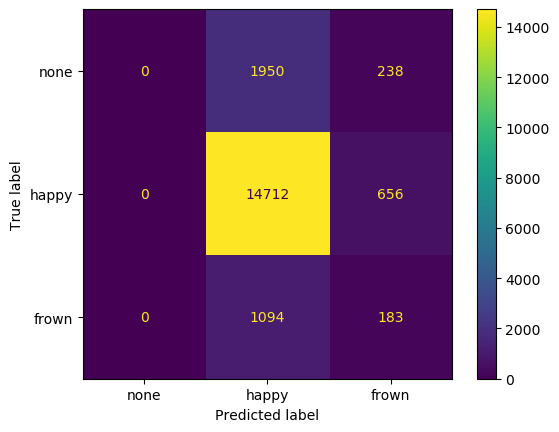

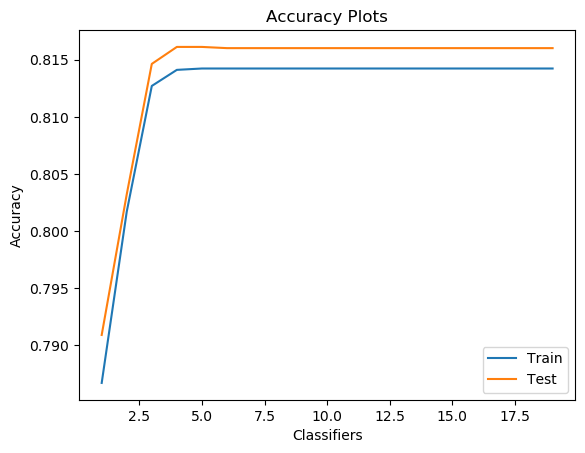

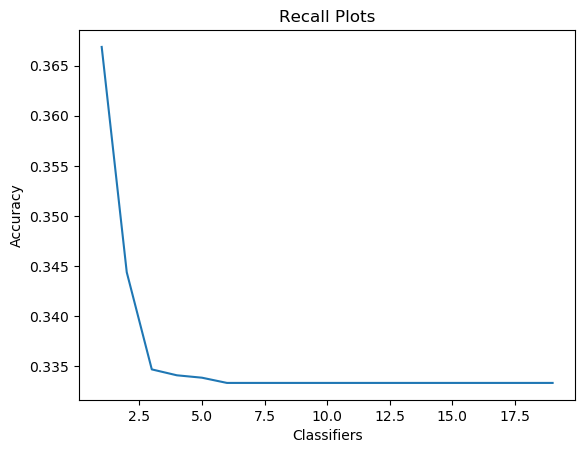

{'hyperparameters': 'var_smoothing: 1e-10', 'train_acc': 0.7866985264834727, 'test_acc': 0.790898953963787, 'recall_score': 0.36687283973817797, 'time': datetime.timedelta(microseconds=11299), 'confusion_matrix': array([[    0,  1950,   238],
       [    0, 14712,   656],
       [    0,  1094,   183]])}


In [89]:
gnb_classifier = gnb_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


K NEAREST NEIGHBOURS


Classifier 1.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 1
Train Accuray: 98.93535112173105% ..........  Test Accuracy: 97.75394254765571% ..........   Time Required:0:00:00.061189
Recall Score: 0.9313789103937303
Classifier 2.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 2
Train Accuray: 99.03093057214922% ..........  Test Accuracy: 98.0194339722827% ..........   Time Required:0:00:00.060468
Recall Score: 0.9372293947400397
Classifier 3.....
Hyperparameters... n_neighbours: 4, weight: uniform, distance_metric: 3
Train Accuray: 99.04155051108457% ..........  Test Accuracy: 98.05660277173047% ..........   Time Required:0:00:00.062245
Recall Score: 0.9385998909012274
Classifier 4.....
Hyperparameters... n_neighbours: 4, weight: distance, distance_metric: 1
Train Accuray: 100.0% ..........  Test Accuracy: 98.20527796952159% ..........   Time Required:0:00:00.062434
Recall Score: 0.9623107933015446
Classifie

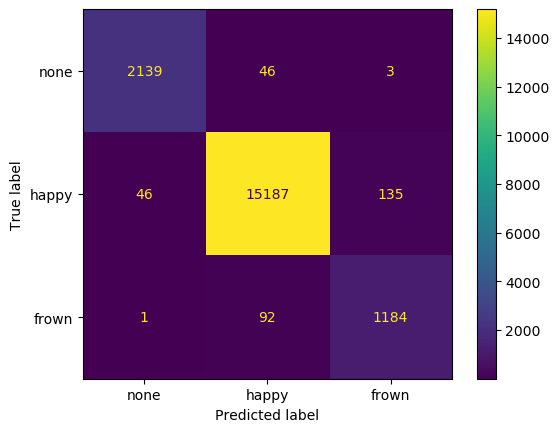

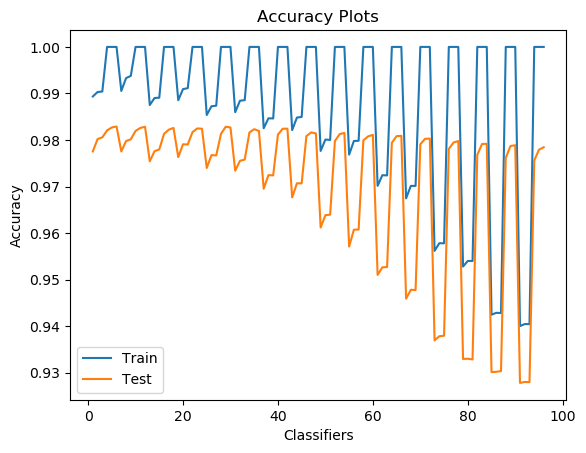

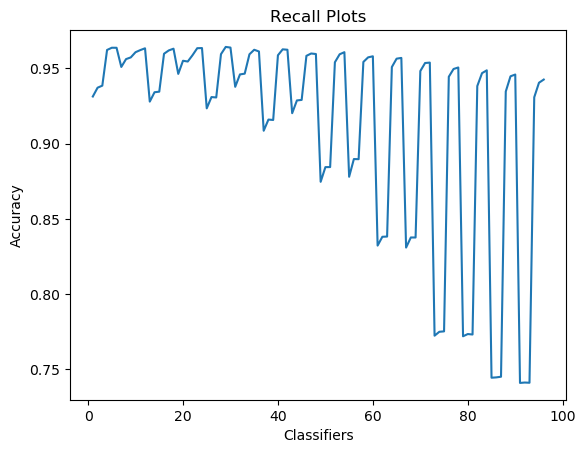

{'hyperparameters': 'n_neighbours: 8, weight: distance, distance_metric: 2', 'train_acc': 1.0, 'test_acc': 0.9828492539690968, 'recall_score': 0.9643334869187309, 'time': datetime.timedelta(microseconds=64541), 'confusion_matrix': array([[ 2139,    46,     3],
       [   46, 15187,   135],
       [    1,    92,  1184]])}


In [90]:
knn_classifier = knn_search(x_train4, y_train4.astype('int'), x_test4, y_test4.astype('int'))


In [91]:
save_model('saved_models/new_data2_lda_models/', 'dtc.pkl', dtc_classifier)
save_model('saved_models/new_data2_lda_models/', 'xgb.pkl', xgb_classifier)
save_model('saved_models/new_data2_lda_models/', 'bag.pkl', bagging_classifier)
save_model('saved_models/new_data2_lda_models/', 'rfc.pkl', rfc_classifier)
save_model('saved_models/new_data2_lda_models/', 'gnb.pkl', gnb_classifier)
save_model('saved_models/new_data2_lda_models/', 'knn.pkl', knn_classifier)